In [104]:
import sys
sys.path.append('../RecSysRep/')

In [105]:
import Basics.Load as ld
import scipy.sparse as sps

URM_all, ICM1, ICM2, ICM3, ICM4 = ld.getCOOs()
ICML = ld.getICMlength('5km')
ICM_weighted = ld.getICMselected('7')
ICM_gen = sps.hstack([ICM1, ICM2])
ICM_all = sps.hstack([ICM1, ICM2, ICM3, ICML])
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [106]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=5555)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions


In [107]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'IALS_Hyb' : {"num_factors": 28, "epochs": 10, "confidence_scaling": "linear", "alpha": 0.43657990940994623, "epsilon": 0.35472063248578317, "reg": 0.0001698292271931609, "mw": 0.06122362507952762},
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' :  {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_weighted': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                            'SLIM_BPR_Hyb' : {"epochs": 1443, "lambda_i": 8.900837513818856e-05, "lambda_j": 1.2615223007492727e-05, "learning_rate": 0.0037706733838839264, "topK": 6181, "random_seed": 1234, "sgd_mode": "sgd"}
                         }


In [108]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [109]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython_Hybrid
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIM_S_ElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender_Hybrid
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

In [110]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridTwoRecommender

In [113]:
recommender1 = MultiThreadSLIM_SLIM_S_ElasticNetRecommender(URM_train, ICM_weighted)
recommender2 = IALSRecommender(URM_train)
recommender3 = RP3betaRecommender(URM_train)

model_init(recommender1, 'SLIM_weig_5555', models_to_combine_best['SLIMweig'])
model_init(recommender2, 'IALS_5555', models_to_combine_best['SLIM_BPR_Hyb'])
model_init(recommender3, 'RP3beta_5555', models_to_combine_best['RP3beta'])

../models_temp/Similarity_Hybrid/SLIM_weig_5555.zip
Model does not exists, creating...
(13887, 18059)



 12%|█████████                                                                    | 2120/18059 [02:04<12:29, 21.25it/s]


 13%|█████████▋                                                                   | 2272/18059 [05:35<38:53,  6.77it/s]

 24%|██████████████████▎                                                          | 4296/18059 [04:04<14:27, 15.86it/s]


 36%|███████████████████████████▍                                                 | 6440/18059 [05:59<08:47, 22.01it/s]


 47%|████████████████████████████████████▎                                        | 8520/18059 [07:54<08:57, 17.75it/s]


 59%|█████████████████████████████████████████████                               | 10696/18059 [10:02<11:34, 10.60it/s]


 71%|██████████████████████████████████████████████████████                      | 12832/18059 [11:57<03:27, 25.17it/s]


 74%|████████████████████████████████████████████████████████▍                   | 13416/18059 [12:57<06:58, 11.09it/s]

KeyboardInterrupt: 

In [34]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [35]:
def rank_models_evaluator_based(evaluators, recommenders):
    j = 0
    for e in evaluators:
        for r in recommenders:
            r_d, _ = e.evaluateRecommender(r)
            print("GROUP " + str(j), r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])
        j += 1

In [44]:
import numpy as np

def test_percentage_sim(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_a.W_sparse, recommender_b.W_sparse)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

def test_percentage_sco(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNScoresHybridTwoRecommender(URM_train, recommender_a, recommender_b)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 10000 (73.3%) in 5.41 min. Users per second: 31
EvaluatorHoldout: Processed 13647 (100.0%) in 7.12 min. Users per second: 32
             MAP
cutoff          
10      0.223053
0.0 : 0.22305285713122608
EvaluatorHoldout: Processed 10000 (73.3%) in 5.28 min. Users per second: 32
EvaluatorHoldout: Processed 13647 (100.0%) in 6.95 min. Users per second: 33
             MAP
cutoff          
10      0.232507
0.05263157894736842 : 0.23250743811361502
EvaluatorHoldout: Processed 10000 (73.3%) in 5.29 min. Users per second: 31
EvaluatorHoldout: Processed 13647 (100.0%) in 6.90 min. Users per second: 33
             MAP
cutoff          
10      0.238851
0.10526315789473684 : 0.23885052357573716
EvaluatorHoldout: Processed 10000 (73.3%) in 5.21 min. Users per second: 32
EvaluatorHoldout: Processed 13647 (100.0%) in 6.85 min. Users per second: 33
             MAP
cutoff          
10      0.243113
0.15789473684210525 : 0.24311344955167705
EvaluatorHoldout: Processed 1000

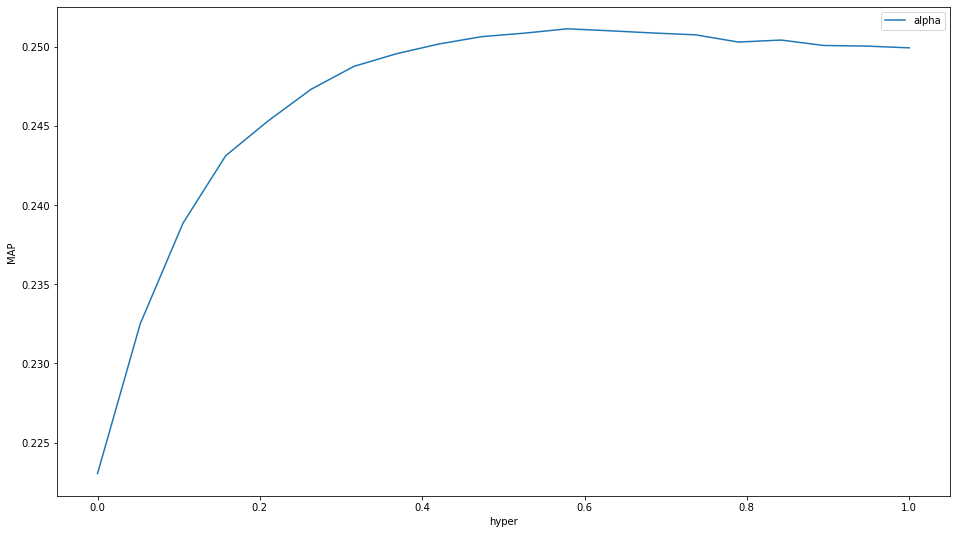

In [97]:
alp_space, results = test_percentage_sco(recommender1, recommender3, evaluator_validation, 0, 1, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13647 (100.0%) in 17.23 sec. Users per second: 792
             MAP
cutoff          
10      0.223053
0.0 : 0.22305285713122608
EvaluatorHoldout: Processed 13647 (100.0%) in 17.85 sec. Users per second: 764
             MAP
cutoff          
10      0.236345
0.05263157894736842 : 0.23634478360846725
EvaluatorHoldout: Processed 13647 (100.0%) in 18.28 sec. Users per second: 746
           MAP
cutoff        
10      0.2433
0.10526315789473684 : 0.2432997978507978
EvaluatorHoldout: Processed 13647 (100.0%) in 18.92 sec. Users per second: 721
             MAP
cutoff          
10      0.246496
0.15789473684210525 : 0.24649611054700096
EvaluatorHoldout: Processed 13647 (100.0%) in 17.95 sec. Users per second: 760
             MAP
cutoff          
10      0.248697
0.21052631578947367 : 0.24869650693623116
EvaluatorHoldout: Processed 13647 (100.0%) in 19.01 sec. Users per second: 718
             MAP
cutoff          
10      0.249568
0.2631578947368421 : 0.2495681706

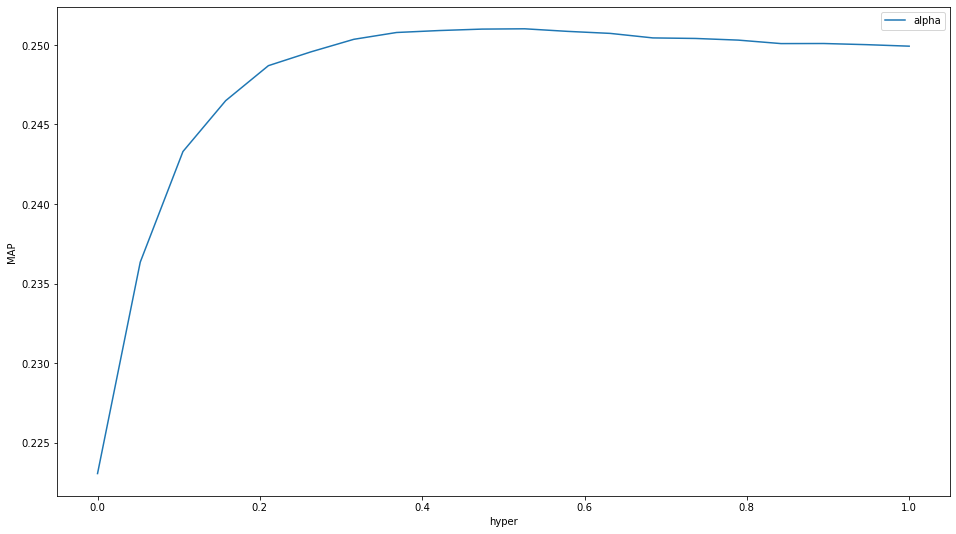

In [98]:
alp_space, results = test_percentage_sim(recommender1, recommender3, evaluator_validation, 0, 1, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 6553 (100.0%) in 1.93 min. Users per second: 56
             MAP
cutoff          
10      0.212894
0.3 : 0.2128941790867625
EvaluatorHoldout: Processed 6553 (100.0%) in 2.13 min. Users per second: 51
            MAP
cutoff         
10      0.21296
0.30168067226890755 : 0.2129597131085
EvaluatorHoldout: Processed 6553 (100.0%) in 2.11 min. Users per second: 52
             MAP
cutoff          
10      0.212982
0.3033613445378151 : 0.21298197965792962
EvaluatorHoldout: Processed 6553 (100.0%) in 1.96 min. Users per second: 56
             MAP
cutoff          
10      0.213018
0.30504201680672266 : 0.21301837399082926
EvaluatorHoldout: Processed 6553 (100.0%) in 2.05 min. Users per second: 53
            MAP
cutoff         
10      0.21301
0.3067226890756302 : 0.21301013833479868
EvaluatorHoldout: Processed 6553 (100.0%) in 2.06 min. Users per second: 53
             MAP
cutoff          
10      0.213063
0.30840336134453783 : 0.21306327042745454
EvaluatorHoldou

EvaluatorHoldout: Processed 6553 (100.0%) in 1.80 min. Users per second: 61
             MAP
cutoff          
10      0.213303
0.38235294117647056 : 0.21330286140601948
EvaluatorHoldout: Processed 6553 (100.0%) in 1.79 min. Users per second: 61
            MAP
cutoff         
10      0.21325
0.3840336134453781 : 0.21324992914913474
EvaluatorHoldout: Processed 6553 (100.0%) in 1.80 min. Users per second: 61
             MAP
cutoff          
10      0.213287
0.3857142857142857 : 0.21328699565690176
EvaluatorHoldout: Processed 6553 (100.0%) in 1.78 min. Users per second: 61
             MAP
cutoff          
10      0.213293
0.3873949579831933 : 0.21329252444657523
EvaluatorHoldout: Processed 6553 (100.0%) in 1.79 min. Users per second: 61
             MAP
cutoff          
10      0.213345
0.38907563025210085 : 0.21334518420013532
EvaluatorHoldout: Processed 6553 (100.0%) in 1.79 min. Users per second: 61
             MAP
cutoff          
10      0.213279
0.3907563025210084 : 0.21327934134

EvaluatorHoldout: Processed 6553 (100.0%) in 1.78 min. Users per second: 61
             MAP
cutoff          
10      0.212818
0.4647058823529412 : 0.21281801743536743
EvaluatorHoldout: Processed 6553 (100.0%) in 1.80 min. Users per second: 61
             MAP
cutoff          
10      0.212733
0.46638655462184875 : 0.21273272995041576
EvaluatorHoldout: Processed 6553 (100.0%) in 1.79 min. Users per second: 61
            MAP
cutoff         
10      0.21272
0.4680672268907563 : 0.2127195347338786
EvaluatorHoldout: Processed 6553 (100.0%) in 1.81 min. Users per second: 60
             MAP
cutoff          
10      0.212703
0.46974789915966386 : 0.21270283330789896
EvaluatorHoldout: Processed 6553 (100.0%) in 1.81 min. Users per second: 60
             MAP
cutoff          
10      0.212679
0.4714285714285714 : 0.21267920424184644
EvaluatorHoldout: Processed 6553 (100.0%) in 1.81 min. Users per second: 60
             MAP
cutoff          
10      0.212723
0.473109243697479 : 0.2127227321062

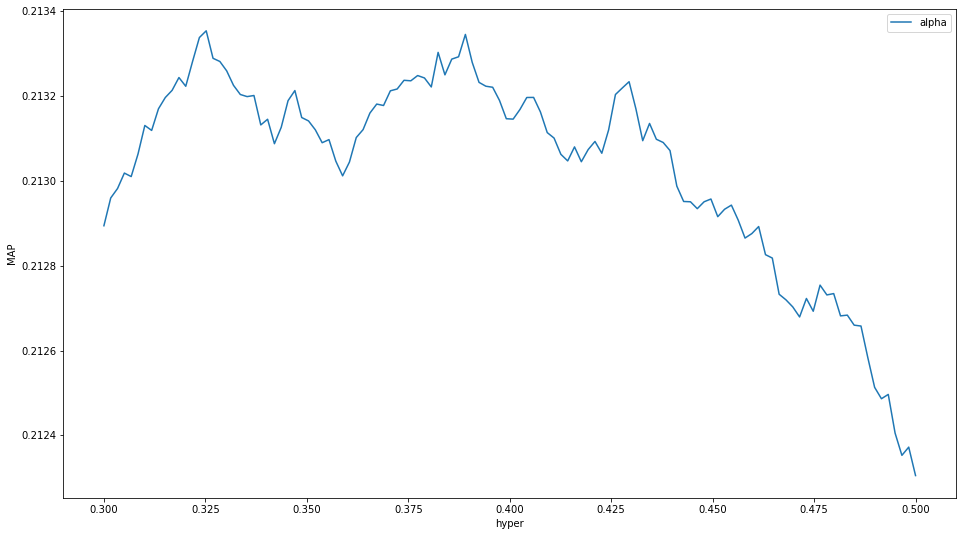

In [60]:
import matplotlib.pyplot as plt
import numpy as np

#group 1
alp_space, results = test_percentage_sco(recommender1, recommender2, evaluators[1], 0.3, 0.5, 120)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

In [70]:
best_on_1 = 0.07095
recommender_gr_1 = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender1.W_sparse, recommender2.W_sparse)
recommender_gr_1.fit(best_on_1)
recommender_gr_1.RECOMMENDER_NAME = 'RP3+BPR on 1'

EvaluatorHoldout: Processed 409 (100.0%) in 0.27 sec. Users per second: 1531
             MAP
cutoff          
10      0.153098
0.6398 : 0.15309756665502397
EvaluatorHoldout: Processed 409 (100.0%) in 0.29 sec. Users per second: 1430
             MAP
cutoff          
10      0.153106
0.6403867368421053 : 0.1531057166142742
EvaluatorHoldout: Processed 409 (100.0%) in 0.29 sec. Users per second: 1388
             MAP
cutoff          
10      0.153106
0.6409734736842105 : 0.1531057166142742
EvaluatorHoldout: Processed 409 (100.0%) in 0.28 sec. Users per second: 1480
             MAP
cutoff          
10      0.153088
0.6415602105263158 : 0.1530882524158809
EvaluatorHoldout: Processed 409 (100.0%) in 0.28 sec. Users per second: 1473
             MAP
cutoff          
10      0.153088
0.642146947368421 : 0.1530882524158809
EvaluatorHoldout: Processed 409 (100.0%) in 0.27 sec. Users per second: 1491
             MAP
cutoff          
10      0.153096
0.6427336842105263 : 0.15309649939845554
Eva

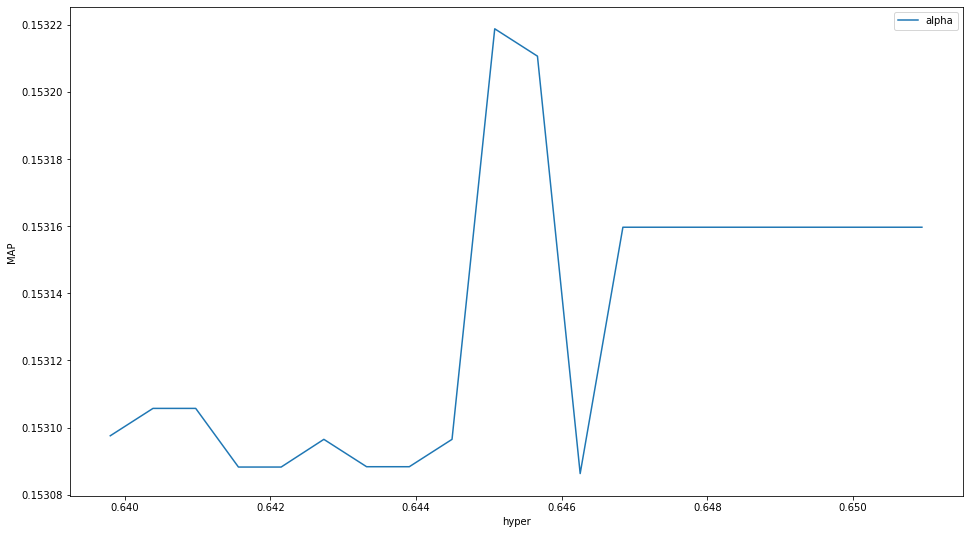

In [73]:
#group 2
alp_space, results = test_percentage(recommender1, recommender3, evaluators[2], 0.6398, 0.650948, 20)


_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import numpy as np

def test_percentage(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_a.W_sparse, recommender_b.W_sparse)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [ ]:
alp_space, results = test_percentage(recommender1, recommender2, recommender3, evaluator_validation, 0.5, 1, 0.1, 0.3, 0.01, 0.2, 25)

_ = plt.figure(figsize=(16, 9))
plt.plot(results, alp_space, label='alpha')
plt.plot(results, beta_space, label='beta')
plt.plot(results, gamma_space, label='gamma')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.819672131147541
ItemKNNSimilarityHybridRecommender with weight beta: 0.1639344262295082
IALSRecommender_Hybrid with weight gamma: 0.01639344262295082
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.01 : 0.25007509519970156
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8091706001348618
ItemKNNSimilarityHybridRecommender with weight beta: 0.16183412002697237
IALSRecommender_Hybrid with weight gamma: 0.028995279838165883
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 142
0.5 0.1 0.017916666666666668 : 0.2502300615816704
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7989347536617842
ItemKNNSimilarityHybridRecommender with weight beta: 0.15978695073235685
IALSRecommender_Hybrid with weight gamma: 0.041278295605858856
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.02583

0.5 0.1 0.19208333333333336 : 0.24877541131041106
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.625
ItemKNNSimilarityHybridRecommender with weight beta: 0.125
IALSRecommender_Hybrid with weight gamma: 0.25
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.2 : 0.2485514811363234
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8086253369272236
ItemKNNSimilarityHybridRecommender with weight beta: 0.17520215633423178
IALSRecommender_Hybrid with weight gamma: 0.016172506738544472
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 147
0.5 0.10833333333333334 0.01 : 0.2501491781935973
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7984031936127743
ItemKNNSimilarityHybridRecommender with weight beta: 0.17298735861610112
IALSRecommender_Hybrid with weight gamma: 0.028609447771124414
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.1

0.5 0.10833333333333334 0.17625000000000002 : 0.24903851501264118
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6309148264984227
ItemKNNSimilarityHybridRecommender with weight beta: 0.13669821240799157
IALSRecommender_Hybrid with weight gamma: 0.23238696109358573
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 147
0.5 0.10833333333333334 0.1841666666666667 : 0.24884299640841498
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.62467464862051
ItemKNNSimilarityHybridRecommender with weight beta: 0.1353461738677772
IALSRecommender_Hybrid with weight gamma: 0.23997917751171263
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.10833333333333334 0.19208333333333336 : 0.2486859910716471
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6185567010309279
ItemKNNSimilarityHybridRecommender with weight beta: 0.13402061855670103
IALSRecommender_Hybrid with weight gamma: 0.247

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.11666666666666667 0.16041666666666668 : 0.24918857743199907
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6369426751592356
ItemKNNSimilarityHybridRecommender with weight beta: 0.14861995753715498
IALSRecommender_Hybrid with weight gamma: 0.21443736730360938
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 157
0.5 0.11666666666666667 0.16833333333333336 : 0.24918986886699288
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.630583289542827
ItemKNNSimilarityHybridRecommender with weight beta: 0.14713610089332632
IALSRecommender_Hybrid with weight gamma: 0.22228060956384657
EvaluatorHoldout: Processed 13643 (100.0%) in 1.52 min. Users per second: 150
0.5 0.11666666666666667 0.17625000000000002 : 0.24899512105167043
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6243496357960457
ItemKNNSimilarityHybridRecommender wit

EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.125 0.15250000000000002 : 0.2493095156653392
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.636604774535809
ItemKNNSimilarityHybridRecommender with weight beta: 0.15915119363395225
IALSRecommender_Hybrid with weight gamma: 0.20424403183023876
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.125 0.16041666666666668 : 0.24918669845225605
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6302521008403361
ItemKNNSimilarityHybridRecommender with weight beta: 0.15756302521008403
IALSRecommender_Hybrid with weight gamma: 0.21218487394957986
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.125 0.16833333333333336 : 0.2491121907973044
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.62402496099844
ItemKNNSimilarityHybridRecommender with weight beta: 0.15600624024961
IALSRecommende

EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.13333333333333333 0.1366666666666667 : 0.24953763718588232
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6427423674343867
ItemKNNSimilarityHybridRecommender with weight beta: 0.17139796464916981
IALSRecommender_Hybrid with weight gamma: 0.1858596679164435
EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.13333333333333333 0.14458333333333334 : 0.2495011745077721
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6362672322375397
ItemKNNSimilarityHybridRecommender with weight beta: 0.1696712619300106
IALSRecommender_Hybrid with weight gamma: 0.19406150583244966
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.13333333333333333 0.15250000000000002 : 0.24928622911452952
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6299212598425197
ItemKNNSimilarityHybridRecommender with w

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.14166666666666666 0.12083333333333333 : 0.24990602774374737
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6489994591671174
ItemKNNSimilarityHybridRecommender with weight beta: 0.1838831800973499
IALSRecommender_Hybrid with weight gamma: 0.16711736073553274
EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.14166666666666666 0.12875 : 0.2497703718052994
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6423982869379015
ItemKNNSimilarityHybridRecommender with weight beta: 0.18201284796573874
IALSRecommender_Hybrid with weight gamma: 0.17558886509635976
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 157
0.5 0.14166666666666666 0.1366666666666667 : 0.2496473975257978
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6359300476947537
ItemKNNSimilarityHybridRecommender with weight beta: 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.15000000000000002 0.105 : 0.24993403501301448
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6553795740032768
ItemKNNSimilarityHybridRecommender with weight beta: 0.1966138722009831
IALSRecommender_Hybrid with weight gamma: 0.14800655379574001
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.15000000000000002 0.11291666666666667 : 0.24988978009538063
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6486486486486486
ItemKNNSimilarityHybridRecommender with weight beta: 0.1945945945945946
IALSRecommender_Hybrid with weight gamma: 0.15675675675675674
EvaluatorHoldout: Processed 13643 (100.0%) in 1.53 min. Users per second: 148
0.5 0.15000000000000002 0.12083333333333333 : 0.24987755509250098
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6420545746388443
ItemKNNSimilarityHybridRecommender with weight beta: 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.15833333333333333 0.08916666666666667 : 0.25020284255313274
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6618863761720905
ItemKNNSimilarityHybridRecommender with weight beta: 0.20959735245449532
IALSRecommender_Hybrid with weight gamma: 0.12851627137341426
EvaluatorHoldout: Processed 13643 (100.0%) in 1.51 min. Users per second: 151
0.5 0.15833333333333333 0.09708333333333334 : 0.2500935941333956
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6550218340611353
ItemKNNSimilarityHybridRecommender with weight beta: 0.20742358078602618
IALSRecommender_Hybrid with weight gamma: 0.13755458515283842
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.15833333333333333 0.105 : 0.24990455015596236
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6482982171799028
ItemKNNSimilarityHybridRecommender with weight beta:

EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.16666666666666669 0.07333333333333333 : 0.2502137150396338
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6685236768802227
ItemKNNSimilarityHybridRecommender with weight beta: 0.22284122562674094
IALSRecommender_Hybrid with weight gamma: 0.1086350974930362
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.16666666666666669 0.08125 : 0.25017748505251325
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6615214994487321
ItemKNNSimilarityHybridRecommender with weight beta: 0.22050716648291072
IALSRecommender_Hybrid with weight gamma: 0.11797133406835722
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 156
0.5 0.16666666666666669 0.08916666666666667 : 0.25016482084539016
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6546644844517184
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 154
0.5 0.175 0.0575 : 0.2504419180020236
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6752954417557681
ItemKNNSimilarityHybridRecommender with weight beta: 0.23635340461451881
IALSRecommender_Hybrid with weight gamma: 0.08835115362971299
EvaluatorHoldout: Processed 13643 (100.0%) in 1.48 min. Users per second: 154
0.5 0.175 0.06541666666666666 : 0.25038916404598516
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6681514476614698
ItemKNNSimilarityHybridRecommender with weight beta: 0.23385300668151443
IALSRecommender_Hybrid with weight gamma: 0.09799554565701558
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.175 0.07333333333333333 : 0.25021131541380126
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6611570247933883
ItemKNNSimilarityHybridRecommender with weight beta: 0.2314049586776859
IALSRecommender_Hybri

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.18333333333333335 0.04958333333333334 : 0.25040902713060686
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6749156355455568
ItemKNNSimilarityHybridRecommender with weight beta: 0.24746906636670418
IALSRecommender_Hybrid with weight gamma: 0.07761529808773904
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.18333333333333335 0.0575 : 0.25048232188377445
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.667779632721202
ItemKNNSimilarityHybridRecommender with weight beta: 0.24485253199777407
IALSRecommender_Hybrid with weight gamma: 0.08736783528102392
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.18333333333333335 0.06541666666666666 : 0.25040525753657134
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6607929515418501
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.19166666666666665 0.03375 : 0.25036832075056925
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6818181818181819
ItemKNNSimilarityHybridRecommender with weight beta: 0.26136363636363635
IALSRecommender_Hybrid with weight gamma: 0.05681818181818183
EvaluatorHoldout: Processed 13643 (100.0%) in 1.51 min. Users per second: 151
0.5 0.19166666666666665 0.04166666666666667 : 0.2503839634023614
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6745362563237775
ItemKNNSimilarityHybridRecommender with weight beta: 0.25857223159078135
IALSRecommender_Hybrid with weight gamma: 0.06689151208544127
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.19166666666666665 0.04958333333333334 : 0.2503588502272816
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6674082313681869
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.2 0.017916666666666668 : 0.2502135172522928
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6888633754305397
ItemKNNSimilarityHybridRecommender with weight beta: 0.2755453501722159
IALSRecommender_Hybrid with weight gamma: 0.03559127439724455
EvaluatorHoldout: Processed 13643 (100.0%) in 1.62 min. Users per second: 140
0.5 0.2 0.025833333333333333 : 0.2502625307006692
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6814310051107326
ItemKNNSimilarityHybridRecommender with weight beta: 0.27257240204429306
IALSRecommender_Hybrid with weight gamma: 0.045996592844974454
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.2 0.03375 : 0.25034700334726107
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6741573033707866
ItemKNNSimilarityHybridRecommender with weight beta: 0.26966292134831465
IALSRecommender_Hybrid w

EvaluatorHoldout: Processed 13643 (100.0%) in 1.13 min. Users per second: 201
0.5 0.20833333333333334 0.01 : 0.24995799055042045
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6884681583476764
ItemKNNSimilarityHybridRecommender with weight beta: 0.28686173264486514
IALSRecommender_Hybrid with weight gamma: 0.024670109007458405
EvaluatorHoldout: Processed 13643 (100.0%) in 1.43 min. Users per second: 160
0.5 0.20833333333333334 0.017916666666666668 : 0.25017102787754547
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.681044267877412
ItemKNNSimilarityHybridRecommender with weight beta: 0.28376844494892167
IALSRecommender_Hybrid with weight gamma: 0.03518728717366629
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.20833333333333334 0.025833333333333333 : 0.25025893562487567
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.673778775968557
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.20833333333333334 0.19208333333333336 : 0.2486025015444872
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5504587155963302
ItemKNNSimilarityHybridRecommender with weight beta: 0.2293577981651376
IALSRecommender_Hybrid with weight gamma: 0.2201834862385321
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.20833333333333334 0.2 : 0.2486471025899681
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6880733944954128
ItemKNNSimilarityHybridRecommender with weight beta: 0.2981651376146789
IALSRecommender_Hybrid with weight gamma: 0.013761467889908258
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.21666666666666667 0.01 : 0.24999207105452184
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6806579693703914
ItemKNNSimilarityHybridRecommender with weight beta: 0.2949517867271696


EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.21666666666666667 0.17625000000000002 : 0.24887895298362223
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5550416281221091
ItemKNNSimilarityHybridRecommender with weight beta: 0.24051803885291398
IALSRecommender_Hybrid with weight gamma: 0.2044403330249769
EvaluatorHoldout: Processed 13643 (100.0%) in 1.53 min. Users per second: 149
0.5 0.21666666666666667 0.1841666666666667 : 0.24872611281557308
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5502063273727648
ItemKNNSimilarityHybridRecommender with weight beta: 0.2384227418615314
IALSRecommender_Hybrid with weight gamma: 0.21137093076570382
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 141
0.5 0.21666666666666667 0.19208333333333336 : 0.24864042726719612
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5454545454545454
ItemKNNSimilarityHybridRecommender with 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.225 0.16833333333333336 : 0.24898088618036598
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5547850208044383
ItemKNNSimilarityHybridRecommender with weight beta: 0.24965325936199723
IALSRecommender_Hybrid with weight gamma: 0.19556171983356452
EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 154
0.5 0.225 0.17625000000000002 : 0.24883682718854588
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5499541704857929
ItemKNNSimilarityHybridRecommender with weight beta: 0.24747937671860679
IALSRecommender_Hybrid with weight gamma: 0.2025664527956004
EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.225 0.1841666666666667 : 0.24870168317027536
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5452067242162654
ItemKNNSimilarityHybridRecommender with weight beta: 0.2453430258973194
IALSRecom

EvaluatorHoldout: Processed 13643 (100.0%) in 1.63 min. Users per second: 139
0.5 0.23333333333333334 0.15250000000000002 : 0.2493290122616529
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5594405594405594
ItemKNNSimilarityHybridRecommender with weight beta: 0.26107226107226106
IALSRecommender_Hybrid with weight gamma: 0.1794871794871795
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.23333333333333334 0.16041666666666668 : 0.2490926796578055
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.55452865064695
ItemKNNSimilarityHybridRecommender with weight beta: 0.2587800369685767
IALSRecommender_Hybrid with weight gamma: 0.18669131238447323
EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.23333333333333334 0.16833333333333336 : 0.24896511845716582
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5497022446174988
ItemKNNSimilarityHybridRecommender with wei

EvaluatorHoldout: Processed 13643 (100.0%) in 1.52 min. Users per second: 150
0.5 0.24166666666666667 0.1366666666666667 : 0.2495716478826869
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5641748942172073
ItemKNNSimilarityHybridRecommender with weight beta: 0.27268453220498357
IALSRecommender_Hybrid with weight gamma: 0.16314057357780914
EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 155
0.5 0.24166666666666667 0.14458333333333334 : 0.24941229818419677
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.559179869524697
ItemKNNSimilarityHybridRecommender with weight beta: 0.27027027027027023
IALSRecommender_Hybrid with weight gamma: 0.17054986020503263
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.24166666666666667 0.15250000000000002 : 0.24932474819926398
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5542725173210161
ItemKNNSimilarityHybridRecommender with 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.63 min. Users per second: 140
0.5 0.25 0.12875 : 0.24960668823712107
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5639097744360902
ItemKNNSimilarityHybridRecommender with weight beta: 0.2819548872180451
IALSRecommender_Hybrid with weight gamma: 0.15413533834586468
EvaluatorHoldout: Processed 13643 (100.0%) in 1.66 min. Users per second: 137
0.5 0.25 0.1366666666666667 : 0.24950665147194528
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5589194224499302
ItemKNNSimilarityHybridRecommender with weight beta: 0.2794597112249651
IALSRecommender_Hybrid with weight gamma: 0.1616208663251048
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 142
0.5 0.25 0.14458333333333334 : 0.24942826078610048
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5540166204986149
ItemKNNSimilarityHybridRecommender with weight beta: 0.27700831024930744
IALSRecommender_Hybrid wi

0.5 0.2583333333333333 0.11291666666666667 : 0.24970837419968892
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5687203791469194
ItemKNNSimilarityHybridRecommender with weight beta: 0.2938388625592417
IALSRecommender_Hybrid with weight gamma: 0.13744075829383887
EvaluatorHoldout: Processed 13643 (100.0%) in 1.88 min. Users per second: 121
0.5 0.2583333333333333 0.12083333333333333 : 0.24963840111040098
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5636449037106623
ItemKNNSimilarityHybridRecommender with weight beta: 0.29121653358384214
IALSRecommender_Hybrid with weight gamma: 0.14513856270549555
EvaluatorHoldout: Processed 13643 (100.0%) in 1.24 min. Users per second: 183
0.5 0.2583333333333333 0.12875 : 0.24954480406836926
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5586592178770949
ItemKNNSimilarityHybridRecommender with weight beta: 0.2886405959031657
IALSRecommender_Hybrid with weight gamma: 0.152700186219739

In [69]:
recommender1a = MultiThreadSLIM_SLIM_S_ElasticNetRecommender(URM_all, ICM_gen)
recommender2a = SLIM_BPR_Cython_Hybrid(URM_all, ICM_all)
recommender3a = RP3betaRecommender(URM_all)
recommender4a = P3alphaRecommender(URM_all)
recommender5a = IALSRecommender(URM_all)
recommender6a = UserKNNCFRecommender(URM_all)

ofp = '../all_models/'

model_init(recommender1a, 'SLIM_gen', models_to_combine_best['SLIMgensub'])
model_init(recommender2a, 'BPR_hyb', models_to_combine_best['SLIM_BPR_Hyb'])
model_init(recommender3a, 'RP3beta', models_to_combine_best['RP3beta'])
model_init(recommender4a, 'P3alpha', models_to_combine_best['P3alpha'])
model_init(recommender5a, 'IALS', models_to_combine_best['IALS'])
model_init(recommender6a, 'USERKNN', models_to_combine_best['UserKNN'])

../all_models/SLIM_gen.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../all_models/SLIM_gen'
SLIMElasticNetRecommender: Loading complete
../all_models/BPR_hyb.zip
Model found!
SLIM_BPR_Recommender_Hybrid: Loading model from file '../all_models/BPR_hyb'
SLIM_BPR_Recommender_Hybrid: Loading complete
../all_models/RP3beta.zip
Model found!
RP3betaRecommender: Loading model from file '../all_models/RP3beta'
RP3betaRecommender: Loading complete
../all_models/P3alpha.zip
Model found!
P3alphaRecommender: Loading model from file '../all_models/P3alpha'
P3alphaRecommender: Loading complete
../all_models/IALS.zip
Model found!
IALSRecommender: Loading model from file '../all_models/IALS'
IALSRecommender: Loading complete
../all_models/USERKNN.zip
Model found!
UserKNNCFRecommender: Loading model from file '../all_models/USERKNN'
UserKNNCFRecommender: Loading complete


In [79]:
best_on_0 = 0.462159
recommender_gr_0 = ItemKNNScoresHybridTwoRecommender(URM_all.tocsr(), recommender1a, recommender6a)
recommender_gr_0.fit(best_on_0)
recommender_gr_0.RECOMMENDER_NAME = 'SLIM+USER on 0'

best_on_1 = 0.95735
recommender_gr_1 = ItemKNNSimilarityHybridRecommenderNormal(URM_all.tocsr(), recommender1a.W_sparse, recommender2a.W_sparse)
recommender_gr_1.fit(best_on_1)
recommender_gr_1.RECOMMENDER_NAME = 'SLIM+BPR on 1'

best_on_2 = 0.4867503 #0.3
recommender_gr_2 = ItemKNNSimilarityHybridRecommenderNormal(URM_all.tocsr(), recommender1a.W_sparse, recommender3a.W_sparse)
recommender_gr_2.fit(best_on_2)
recommender_gr_2.RECOMMENDER_NAME = 'SLIM+RP3 on 2'

In [90]:
best_on_0 = 0.462159
recommender_gr_0a = ItemKNNScoresHybridTwoRecommender(URM_train.tocsr(), recommender1, recommender6)
recommender_gr_0a.fit(best_on_0)
recommender_gr_0a.RECOMMENDER_NAME = 'SLIM+USER on 0'

best_on_1 = 0.95735
recommender_gr_1a = ItemKNNSimilarityHybridRecommenderNormal(URM_train.tocsr(), recommender1.W_sparse, recommender2.W_sparse)
recommender_gr_1a.fit(best_on_1)
recommender_gr_1a.RECOMMENDER_NAME = 'SLIM+BPR on 1'

best_on_2 = 0.4867503 #0.3
recommender_gr_2a = ItemKNNSimilarityHybridRecommenderNormal(URM_train.tocsr(), recommender1.W_sparse, recommender3.W_sparse)
recommender_gr_2a.fit(best_on_2)
recommender_gr_2a.RECOMMENDER_NAME = 'SLIM+RP3 on 2'

In [92]:
rank_models_evaluator_based(evaluators, [recommender_gr_0a, recommender_gr_1a, recommender_gr_2a])

EvaluatorHoldout: Processed 5442 (100.0%) in 20.71 sec. Users per second: 263
             MAP
cutoff          
10      0.034558
GROUP 0 SLIM+BPR on 1 0.03455776062722043
EvaluatorHoldout: Processed 6553 (100.0%) in 13.60 sec. Users per second: 482
            MAP
cutoff         
10      0.02763
GROUP 1 SLIM+BPR on 1 0.027630426146754525
EvaluatorHoldout: Processed 1648 (100.0%) in 15.01 sec. Users per second: 110
           MAP
cutoff        
10      0.0344
GROUP 2 SLIM+BPR on 1 0.0343997775080907


In [91]:
rank_models(evaluator_validation, [recommender_gr_0a, recommender_gr_1a, recommender_gr_2a])

EvaluatorHoldout: Processed 13647 (100.0%) in 4.15 min. Users per second: 55
             MAP
cutoff          
10      0.251295
SLIM+USER on 0 0.2512954181452756
EvaluatorHoldout: Processed 13647 (100.0%) in 43.05 sec. Users per second: 317
             MAP
cutoff          
10      0.251689
SLIM+BPR on 1 0.2516885215775085
EvaluatorHoldout: Processed 13647 (100.0%) in 17.85 sec. Users per second: 765
             MAP
cutoff          
10      0.250626
SLIM+RP3 on 2 0.25062555756774163


In [89]:
import pandas as pd
K=10

user_test_path = '../data/data_target_users_test.csv'
user_test_dataframe = pd.read_csv(filepath_or_buffer=user_test_path,
                                sep=",",
                                dtype={0:int})

subm_set = user_test_dataframe.to_numpy().T[0]


subm_res = {"user_id":[], "item_list":[]}

print(groups[0], "\n", groups[1], "\n", groups[2], "\n")

for user_id in subm_set:
    subm_res["user_id"].append(user_id)
    res = None
    if user_id in groups[0]:
        res = recommender_gr_0.recommend(user_id, K)
        print(user_id, "in group 0 recommended")
    elif user_id in groups[1]:
        res = recommender_gr_1.recommend(user_id, K)
        print(user_id, "in group 1 recommended")
    elif user_id in groups[2]:
        res = recommender_gr_2.recommend(user_id, K)
        print(user_id, "in group 2 recommended")
    res = ' '.join(map(str, res))
    print(res)
    subm_res["item_list"].append(res)


# print(subm_res)

submission = pd.DataFrame.from_dict(subm_res)
# submission

from datetime import datetime
now = datetime.now() # current date and time


submission.to_csv('../subs/submission {:%Y_%m_%d %H_%M_%S}.csv'.format(now), index=False)

[    1     4    11 ... 13639 13644 13645] 
 [    0     2     3 ... 13647 13648 13649] 
 [   25    26    31 ... 13632 13633 13636] 

0 in group 1 recommended
8465 5433 3899 16365 640 2243 16359 9130 17961 10586
1 in group 0 recommended
3473 16365 14358 53 14400 15119 940 7257 640 2665
2 in group 1 recommended
6177 1551 17330 17022 15119 16365 4607 2846 14229 5925
3 in group 1 recommended
8194 15551 8371 15507 16444 15082 16359 960 9865 16012
4 in group 0 recommended
8194 6177 3473 6011 5299 2152 10954 9871 10586 1619
5 in group 1 recommended
9621 1846 7867 16640 14396 11227 13585 99 13098 1519
6 in group 1 recommended
6214 985 16846 14181 14358 13443 7606 8207 16640 9621
7 in group 1 recommended
13963 15119 14031 1885 7751 3433 4292 17364 640 6710
8 in group 1 recommended
8635 3619 5605 2665 10865 5299 1259 3768 12752 4853
9 in group 1 recommended
5605 3473 8207 15119 14181 1614 13318 1551 6214 15117
10 in group 1 recommended
3899 6214 16365 16846 14358 14400 6975 5273 15181 13229
11 in

111 in group 1 recommended
6177 5951 8580 6976 11058 13585 10857 9621 6351 53
112 in group 0 recommended
13134 13229 16846 3473 3899 17294 12186 1792 5273 3619
113 in group 1 recommended
5273 1551 16364 8326 10865 6724 16012 3200 4078 7224
114 in group 0 recommended
16846 14358 13229 5403 1137 17294 3768 7295 13410 1792
115 in group 1 recommended
3473 7295 5424 13914 12707 13691 739 287 7224 5742
116 in group 0 recommended
9621 17356 409 6905 4559 10095 13691 15800 7295 12975
117 in group 1 recommended
15119 14358 6214 12752 5324 8635 16624 1619 5299 3768
118 in group 1 recommended
17330 3899 6782 8635 249 6975 15996 1792 5324 2665
119 in group 1 recommended
3473 16365 16946 17364 13229 15750 9871 512 16624 13914
120 in group 2 recommended
8635 2665 3942 1259 3200 14868 4088 11481 17364 13318
121 in group 1 recommended
640 13963 12901 8635 2665 1792 3433 10865 6011 3239
122 in group 1 recommended
2665 12901 14868 17416 15778 1792 4853 640 17022 10865
123 in group 2 recommended
13134 13

215 in group 1 recommended
15778 6724 17748 14868 10370 16012 12752 5742 640 5640
216 in group 0 recommended
17330 10562 3829 10370 6905 4088 2665 3768 6670 14868
217 in group 1 recommended
17330 16846 15119 6011 640 2886 5299 9871 6873 14396
218 in group 1 recommended
13963 17294 1137 5324 9871 7295 5299 13914 10954 8207
219 in group 2 recommended
10865 3889 8567 17356 12390 12457 16012 3200 249 17526
220 in group 0 recommended
3899 13914 1551 8502 9871 3889 1515 9441 3619 10295
221 in group 2 recommended
1137 4582 1515 16846 1259 9776 5299 16624 3473 14213
222 in group 2 recommended
11359 4556 249 757 3473 17294 2665 3942 14213 14181
223 in group 1 recommended
15119 16365 6112 8207 13549 13410 17330 16170 1885 4607
224 in group 0 recommended
5273 5925 1941 5403 7309 16486 13914 17135 16012 5742
225 in group 0 recommended
1551 1259 17330 8651 13134 14627 7407 3768 1137 14917
226 in group 0 recommended
2665 17330 15868 3889 12901 7762 1386 10295 14266 16365
227 in group 1 recommended
1

342 in group 1 recommended
3473 16846 17330 2886 10865 1619 9131 8651 890 12015
343 in group 1 recommended
16846 16624 8194 15082 16549 3768 6652 16221 16131 3473
344 in group 0 recommended
6177 4468 13229 1208 13032 3666 8936 12311 17584 8651
345 in group 1 recommended
7264 16846 15119 14396 16365 4582 4292 16624 11662 17356
346 in group 1 recommended
3473 3899 7716 419 11491 14266 287 8567 17135 5925
347 in group 1 recommended
6214 17330 15778 16846 12752 5509 10865 4292 973 5925
348 in group 0 recommended
7264 16365 3869 3200 8635 17330 5403 15117 5605 13410
349 in group 1 recommended
1846 5974 8635 10865 3899 7744 17330 7867 9621 6214
350 in group 0 recommended
15119 13410 10865 11339 4853 5925 17294 10562 17356 7486
351 in group 1 recommended
6177 1846 3473 14358 3899 16962 7867 11430 15119 7606
352 in group 1 recommended
12492 15778 14358 3829 3768 8502 15750 12457 16486 17364
353 in group 1 recommended
13654 3473 5812 17330 16791 6670 4173 12958 2927 6724
354 in group 2 recommen

448 in group 1 recommended
6177 17330 1941 5925 9527 11339 2545 15119 7309 8207
449 in group 0 recommended
6214 6975 1846 11376 9131 10010 11430 15181 17330 12901
450 in group 0 recommended
13229 9131 6652 5925 17670 1551 14400 11359 3200 1259
451 in group 0 recommended
17330 15778 16365 15750 16364 13178 10295 3200 5974 13229
452 in group 0 recommended
8194 6011 8247 12752 1792 15868 7574 985 5100 8635
453 in group 0 recommended
3889 16364 5273 8502 5403 6214 1551 13725 940 16846
454 in group 1 recommended
6177 6975 5424 17330 5324 2772 2587 14095 15785 10914
455 in group 2 recommended
16919 17584 3899 10370 7486 9744 2152 10865 12943 3768
456 in group 0 recommended
640 8635 17294 15119 8207 12752 13229 13134 17788 7716
457 in group 1 recommended
6157 5895 17622 2669 409 17330 6417 6214 13098 4075
458 in group 0 recommended
5258 1517 11973 3899 13134 2665 14358 10095 15750 5299
459 in group 2 recommended
13229 6975 3433 13963 11359 1619 16624 5640 16791 985
460 in group 1 recommended


571 in group 2 recommended
940 3035 16070 1208 3829 3942 17748 12707 14868 4204
572 in group 2 recommended
15996 3899 3889 1941 8448 11491 4088 512 10562 2772
573 in group 1 recommended
3473 17364 3768 14181 8635 13410 1614 8502 5640 13914
574 in group 1 recommended
6214 8635 16846 12186 12614 12707 12832 17364 15778 12958
575 in group 0 recommended
6177 8207 7257 202 9749 15119 10010 11576 1519 6975
576 in group 0 recommended
6214 640 3768 10865 12901 13032 13914 1259 16364 1941
577 in group 1 recommended
6177 1941 17584 17936 10535 12492 2545 15117 13963 3473
578 in group 1 recommended
6177 3473 14868 5974 16365 3942 4204 17022 1137 17526
579 in group 2 recommended
9131 12943 12707 640 15119 6177 15778 17416 14181 3768
580 in group 1 recommended
5742 14181 14400 2456 15996 10865 1551 17022 4078 11339
581 in group 2 recommended
1259 4088 9871 4853 15969 15064 512 14358 16365 3619
582 in group 0 recommended
15119 3768 13229 8207 6011 2152 13914 640 1137 3200
583 in group 0 recommended


698 in group 1 recommended
6214 17584 11339 1551 13318 15119 16846 1941 11491 12186
699 in group 1 recommended
5974 16624 15119 5925 16846 17961 7407 17574 17584 12901
700 in group 1 recommended
7744 13585 2796 17905 8580 11504 11227 15119 13296 409
701 in group 0 recommended
15979 7089 13763 3473 11506 10427 8911 202 17489 8207
702 in group 1 recommended
1846 14358 16624 2846 14237 17294 6589 3899 4623 8635
703 in group 0 recommended
13963 12186 985 13410 4607 16846 9131 6975 3473 14358
704 in group 0 recommended
3899 2665 5403 9441 16364 6306 7407 11342 17022 14485
705 in group 0 recommended
16365 6157 2886 12186 5299 9131 1619 17330 6975 14229
706 in group 0 recommended
16365 2665 14358 14868 13914 1259 5640 1792 17748 8326
707 in group 1 recommended
16365 3899 14358 15181 13229 1885 12792 17788 16791 8635
708 in group 0 recommended
5273 7486 3899 3473 12492 8651 13178 10865 202 13914
709 in group 0 recommended
15979 12752 5675 3910 1232 4292 10562 17294 1259 3829
710 in group 0 rec

830 in group 0 recommended
3899 17330 8635 15551 2665 16070 6214 14181 5981 13801
831 in group 1 recommended
6975 2772 17294 17330 14358 3899 14400 1137 8635 249
832 in group 0 recommended
16846 6214 985 2665 6011 13963 4853 3473 16624 12901
833 in group 1 recommended
7744 6214 99 8580 2886 4119 4582 10865 15119 14181
834 in group 1 recommended
17330 5273 16332 15750 6214 17610 17356 7763 15778 16364
835 in group 0 recommended
3473 14078 2665 13914 3942 1259 249 3829 14400 9871
836 in group 1 recommended
15119 6214 16846 5581 16486 1941 14358 3829 13914 15778
837 in group 0 recommended
6214 3768 13032 1941 15119 13914 6905 6011 17294 249
838 in group 2 recommended
16365 13134 4582 8936 14181 16364 3130 7983 14400 4078
839 in group 1 recommended
15778 1137 13914 17584 5273 17526 10865 2772 8747 14093
840 in group 1 recommended
16846 2665 8635 7744 12186 13229 17140 17364 16946 640
841 in group 0 recommended
640 14781 14229 15064 3899 5925 4645 5640 12015 10865
842 in group 1 recommended

958 in group 1 recommended
3899 6214 3200 7973 8207 12707 1941 17330 1208 640
959 in group 2 recommended
15778 6177 5273 9871 14400 940 15750 17294 15119 3829
960 in group 0 recommended
202 17330 12186 6652 12250 13134 17294 3086 11359 14181
961 in group 1 recommended
3473 11339 5273 17364 1941 17411 10954 15119 1259 1792
962 in group 1 recommended
1846 15596 1246 17330 3899 10008 15154 7744 17274 4562
963 in group 1 recommended
15181 16365 15996 1515 1792 15119 1137 17022 3889 10865
964 in group 0 recommended
15778 2665 249 6975 16486 5974 3200 1551 1259 17748
965 in group 0 recommended
17266 5951 7681 13134 15154 17623 16336 53 9274 13856
966 in group 1 recommended
17330 15778 8747 6214 17526 5925 14358 1137 3889 14400
967 in group 0 recommended
6214 16012 17526 15119 14781 13178 512 5925 940 7224
968 in group 0 recommended
16364 3473 13914 803 1941 249 7716 15996 14917 16012
969 in group 1 recommended
6177 12752 17584 3473 15119 14362 16365 7973 16486 16846
970 in group 0 recommende

1094 in group 1 recommended
2152 3899 16624 8635 15119 12901 14873 4582 1259 13031
1095 in group 1 recommended
3473 3768 15181 3899 17364 15026 1792 2665 6011 1232
1096 in group 0 recommended
3473 14868 3899 8502 1551 5403 10295 13410 13387 17526
1097 in group 2 recommended
17135 16791 5925 10865 6975 10370 3829 14868 17748 5324
1098 in group 1 recommended
16846 3899 12901 10865 7264 17364 14213 14868 6652 14917
1099 in group 0 recommended
7264 10865 5273 5141 6214 940 6782 7309 6905 17751
1100 in group 0 recommended
5925 1614 8502 16364 5403 940 249 241 512 4582
1101 in group 1 recommended
17330 5424 17135 6652 12901 14181 3889 4078 13178 4204
1102 in group 2 recommended
7264 8651 12492 16598 6841 16791 1137 16364 7257 16365
1103 in group 1 recommended
7751 13447 16751 2229 6214 3899 3473 99 6157 8635
1104 in group 0 recommended
14358 8194 6011 13134 9131 15778 13914 13410 14400 12186
1105 in group 2 recommended
7760 13638 5640 12901 10680 4204 6961 1386 15181 4173
1106 in group 0 rec

1230 in group 1 recommended
3899 14868 17291 10370 9610 1614 12457 7716 1551 8854
1231 in group 0 recommended
8635 15119 14181 8207 3955 11491 3768 9744 16365 10865
1232 in group 1 recommended
3473 14917 5577 10295 1515 14266 16364 16070 13318 9441
1233 in group 2 recommended
16962 4721 8986 11359 3473 5974 1185 15119 1137 16598
1234 in group 1 recommended
3473 15119 16846 14181 14213 13032 13410 15181 14358 249
1235 in group 1 recommended
16846 16624 1846 3473 14358 12901 1792 11504 3899 6652
1236 in group 0 recommended
13134 11038 7295 3569 512 13691 16365 3829 8651 9619
1237 in group 0 recommended
7264 5925 16291 8567 17584 2126 442 3768 16342 447
1238 in group 2 recommended
8635 7295 5424 13638 6782 6589 13410 1941 11836 3942
1239 in group 0 recommended
840 15735 5640 14078 6431 4853 3473 8318 14181 8567
1240 in group 2 recommended
3899 3768 13229 6589 16690 12378 12901 11836 6011 17936
1241 in group 0 recommended
6214 9131 6011 640 17294 16624 3473 2665 8194 7374
1242 in group 2 r

1373 in group 0 recommended
16846 3899 17294 1792 9131 17330 12186 4582 12943 15551
1374 in group 1 recommended
12752 4292 3473 7264 11430 13229 13296 552 6976 640
1375 in group 1 recommended
6214 16846 15551 15119 6011 17294 1137 13914 16486 5885
1376 in group 1 recommended
17294 14358 12186 13410 5895 7744 53 4731 5963 8455
1377 in group 1 recommended
5273 3899 17330 17584 7486 12492 10562 13387 6476 14093
1378 in group 0 recommended
7744 3473 10746 11430 17330 11170 4199 1102 15289 10370
1379 in group 1 recommended
2927 6177 8986 6318 8635 5723 3473 12958 2604 1551
1380 in group 1 recommended
10865 8651 17364 1259 1941 1137 2665 10370 8326 15778
1381 in group 1 recommended
14485 14181 11339 17411 5974 9441 13914 6724 1941 6214
1382 in group 1 recommended
6177 2665 3899 1614 12457 8635 3829 4088 3619 955
1383 in group 0 recommended
4292 13229 6177 17364 3768 1619 14781 16751 9131 8936
1384 in group 0 recommended
3473 6214 16791 2665 17364 12943 10562 17584 13914 13178
1385 in group 0

1474 in group 1 recommended
5403 12356 17748 6724 17411 14266 1137 15119 15181 13914
1475 in group 1 recommended
16846 16365 1885 4582 13963 6975 955 14509 3473 12901
1476 in group 0 recommended
12186 17294 9131 14181 4582 16624 13032 1792 10295 11342
1477 in group 1 recommended
6214 3473 6975 4582 640 3768 5299 6652 2387 17330
1478 in group 1 recommended
13229 6975 17294 10027 16624 1619 11359 12901 3200 4582
1479 in group 1 recommended
6177 17330 8635 3829 3619 15778 3433 1614 11038 7295
1480 in group 0 recommended
17330 15922 7257 16846 14762 13630 202 12707 3200 3768
1481 in group 2 recommended
13229 16365 15064 16791 8936 6905 15119 4582 9131 5299
1482 in group 0 recommended
16365 6177 640 3899 17364 17416 10865 2886 17462 4853
1483 in group 1 recommended
15119 16846 16359 5885 249 2678 17364 13410 985 5981
1484 in group 1 recommended
12752 3473 16846 6652 8194 15181 17330 447 2182 638
1485 in group 0 recommended
16365 3899 3473 5963 10865 1259 9131 442 249 202
1486 in group 1 rec

1624 in group 1 recommended
6177 17330 8635 1259 5273 3402 803 5962 5605 10732
1625 in group 1 recommended
15778 13914 17936 17526 5925 2207 512 15119 1792 3768
1626 in group 1 recommended
3473 16070 3899 14917 940 6782 14213 241 17936 1259
1627 in group 1 recommended
6214 14868 14358 6652 5273 1792 249 5299 2886 5640
1628 in group 0 recommended
14181 1386 13914 8207 16624 3889 9441 4607 5640 12457
1629 in group 0 recommended
3473 8567 16365 17330 14181 12371 10562 11854 640 9131
1630 in group 1 recommended
985 3768 5925 5273 5324 6975 3889 4582 640 249
1631 in group 1 recommended
6177 973 16365 3899 15514 15844 5433 640 13229 4582
1632 in group 0 recommended
3899 2152 1792 15119 15778 8635 6589 2665 13134 14868
1633 in group 0 recommended
3899 15119 5925 15778 17936 13963 4204 5742 9871 7295
1634 in group 0 recommended
3768 12707 3200 14181 13410 14400 16436 4582 3080 13630
1635 in group 0 recommended
17330 9131 10865 15119 17294 1137 2665 15922 11576 14520
1636 in group 1 recommended

1725 in group 1 recommended
17623 8159 9778 1887 4791 1246 14396 16336 16365 1784
1726 in group 1 recommended
5273 13914 249 512 6214 14400 4078 13691 16332 3829
1727 in group 1 recommended
6177 17330 11836 16364 8747 14400 15756 3889 13638 10865
1728 in group 1 recommended
8635 17584 14358 5925 10562 15778 15996 17294 8326 4853
1729 in group 0 recommended
14868 10865 14358 8194 5460 249 6652 5433 9131 13229
1730 in group 0 recommended
6177 3473 14266 15969 1259 12617 11662 14213 1846 13638
1731 in group 1 recommended
6670 15778 10370 3942 1137 2055 6975 1846 16012 17584
1732 in group 2 recommended
16598 14868 14996 12457 10914 8651 3636 16038 8636 6782
1733 in group 1 recommended
8635 6961 10865 5273 15969 3569 5925 15674 2851 13691
1734 in group 1 recommended
13410 3473 12792 14358 6873 2665 10316 3433 6011 13134
1735 in group 1 recommended
3899 16365 17330 2665 1792 13914 4204 10843 640 6975
1736 in group 1 recommended
17330 7744 16365 1137 249 1614 1941 17022 6351 10562
1737 in gro

1825 in group 0 recommended
10562 16846 5273 14181 8635 17411 14536 6905 1259 2298
1826 in group 1 recommended
17330 13725 7295 3899 13465 13914 9373 15776 1533 17610
1827 in group 0 recommended
14181 17584 15778 1551 14868 13134 16170 17294 4582 16549
1828 in group 2 recommended
12186 6061 3899 419 9255 13963 11342 4853 8986 985
1829 in group 2 recommended
12380 442 11303 2687 9686 9482 14520 13532 202 2307
1830 in group 0 recommended
13963 10095 14358 985 16365 4607 16619 12975 15927 15868
1831 in group 1 recommended
14396 3668 7744 3899 11430 2251 5895 3198 6652 4119
1832 in group 1 recommended
3473 15007 15119 3768 2083 17830 3913 6148 5885 2886
1833 in group 1 recommended
14037 6975 3899 17330 1619 17294 12901 16624 1137 8635
1834 in group 1 recommended
16070 13465 3569 13318 17966 13691 14400 3942 12390 16353
1835 in group 1 recommended
3899 14181 13134 5925 13725 6905 16365 12457 940 17584
1836 in group 0 recommended
5951 8580 10243 5273 6214 1551 3668 53 15778 8502
1837 in grou

1925 in group 2 recommended
1885 8207 17715 1614 13295 955 16365 3869 15868 16846
1926 in group 1 recommended
6177 14400 14266 249 15119 13914 14213 7264 6476 13638
1927 in group 1 recommended
901 12832 1232 9749 5581 6181 202 7744 3473 1883
1928 in group 1 recommended
8635 15181 3768 5273 17294 5925 16624 6975 1551 5299
1929 in group 0 recommended
3942 14181 14266 17936 4853 1941 13644 6214 13691 2746
1930 in group 1 recommended
4204 17330 15181 3899 16012 7760 12901 14266 1515 16846
1931 in group 0 recommended
7264 2665 5273 1551 899 16846 5675 14358 14610 4582
1932 in group 2 recommended
6975 12752 15082 11844 16486 9131 12943 3955 5640 2886
1933 in group 1 recommended
3473 6214 17330 8207 9130 3889 1137 17022 5605 16444
1934 in group 0 recommended
17935 14627 9744 9322 2179 12492 7973 6177 9973 16919
1935 in group 2 recommended
6214 17330 803 13914 13725 13032 15750 4853 6011 7716
1936 in group 1 recommended
6214 8635 15119 17294 16624 940 16791 14781 6589 1619
1937 in group 2 reco

2025 in group 0 recommended
12186 11491 14358 16365 5925 3213 16946 8371 16791 12530
2026 in group 1 recommended
12752 3899 7716 8473 17364 6975 12764 3473 5299 3433
2027 in group 0 recommended
5925 15922 2687 1259 15383 15119 17135 2152 10562 17563
2028 in group 2 recommended
7264 8194 447 4582 14181 16364 2301 901 3768 6016
2029 in group 0 recommended
7744 1846 6177 53 7867 3899 10243 17330 1603 6214
2030 in group 1 recommended
16846 3899 15181 8194 15082 6975 17788 1267 12752 7975
2031 in group 0 recommended
16846 17788 3473 3768 2152 12752 6589 4607 4292 10865
2032 in group 0 recommended
640 1619 17135 4607 1137 14181 5273 3889 13410 13914
2033 in group 1 recommended
6177 10562 409 7744 388 17330 3473 5273 3899 11343
2034 in group 1 recommended
12371 6177 2545 2126 4396 16291 15583 7919 838 13417
2035 in group 0 recommended
6214 16846 14358 15119 3899 5273 6589 10954 10865 5925
2036 in group 0 recommended
8635 10370 17520 5403 15750 17022 7295 1005 2756 11491
2037 in group 1 recomm

2127 in group 1 recommended
7143 8011 3473 16365 11282 6061 10553 10561 15119 5433
2128 in group 1 recommended
6177 3473 9621 13963 4204 3899 16359 6782 5433 14400
2129 in group 1 recommended
3899 14868 6214 8326 512 17022 17416 5925 4115 14358
2130 in group 0 recommended
5951 53 3198 11376 11430 8465 10010 1519 3473 3899
2131 in group 0 recommended
1551 17584 6177 11339 11776 12492 13584 1259 7412 14627
2132 in group 0 recommended
16364 13229 5925 4582 17830 2152 17364 1619 13032 14868
2133 in group 0 recommended
15119 14181 2665 10295 16365 10865 8635 6975 13032 17022
2134 in group 0 recommended
16365 11058 8194 2665 9131 2482 6151 17330 3200 17291
2135 in group 1 recommended
5273 17526 14266 13638 940 17135 15750 15969 2851 6905
2136 in group 1 recommended
16365 8194 12901 3899 16520 8635 6011 6061 14358 2152
2137 in group 1 recommended
14358 3899 15119 3768 3473 13963 6652 8635 985 6975
2138 in group 1 recommended
4388 16291 7919 2545 11303 15091 13417 3899 6540 8207
2139 in group 

2282 in group 1 recommended
4607 53 6011 985 3899 3473 7751 1619 6250 14229
2283 in group 1 recommended
6177 3473 7264 6214 6652 15119 17574 14762 12752 2687
2284 in group 1 recommended
1941 13295 1846 6351 12457 5925 3942 13914 17520 11491
2285 in group 0 recommended
10562 8635 14181 5273 3899 1551 12457 7407 10370 9744
2286 in group 1 recommended
3899 6214 640 8502 13032 14917 6652 249 9871 7295
2287 in group 1 recommended
3473 5273 8635 11359 6214 8207 14536 6724 16791 16021
2288 in group 0 recommended
6214 2748 6905 10173 16012 7716 16791 5424 7412 9322
2289 in group 0 recommended
6652 6011 5925 1792 13134 13032 16364 249 10295 1619
2290 in group 0 recommended
16364 1044 8502 1386 17936 13032 14181 16791 9441 14375
2291 in group 1 recommended
8096 8207 6730 3132 13134 14794 873 3017 2126 1712
2292 in group 1 recommended
3473 17330 3899 14400 6476 17526 17022 11153 6782 249
2293 in group 1 recommended
3198 4199 552 7867 11430 53 4623 4301 6495 16640
2294 in group 2 recommended
3899 

2435 in group 1 recommended
13585 2796 7744 3668 7606 14396 7867 17622 17291 16846
2436 in group 0 recommended
3899 10865 5273 15119 15778 8986 13134 16846 3942 1614
2437 in group 1 recommended
6670 3899 6676 17330 17356 5812 8502 6214 5605 5273
2438 in group 2 recommended
11339 3579 7870 17135 13443 13134 14781 1259 3889 3829
2439 in group 0 recommended
16846 13229 12943 3473 985 460 17364 3433 7983 8247
2440 in group 0 recommended
13714 17330 14762 8898 5273 17751 3768 7486 11873 202
2441 in group 0 recommended
12186 2665 8635 17330 6652 17364 13410 1551 14181 13585
2442 in group 1 recommended
5299 3899 3473 640 6589 890 16624 10954 14781 14255
2443 in group 1 recommended
6177 1259 16364 15778 3619 14400 8448 14536 4088 3942
2444 in group 0 recommended
12752 16791 12901 2152 14181 13032 15778 6589 12015 13914
2445 in group 1 recommended
6177 2052 5056 6577 4115 552 985 16598 1941 12457
2446 in group 1 recommended
3899 15778 3829 10865 7486 5742 5925 16012 5424 9322
2447 in group 0 re

2588 in group 1 recommended
8635 17294 10865 13229 17364 16791 13134 6652 12901 9898
2589 in group 0 recommended
6214 16365 3768 14358 15119 7257 15773 2532 17761 99
2590 in group 0 recommended
14520 2532 15119 3899 202 13532 13057 17083 8917 4292
2591 in group 0 recommended
8635 4292 2665 6975 8207 17294 7257 3768 11394 5433
2592 in group 0 recommended
13585 17330 8159 10010 15026 1519 7833 14610 4791 14396
2593 in group 1 recommended
3473 13410 12792 7867 12707 14358 3768 12943 6495 2665
2594 in group 0 recommended
6177 14358 12186 5324 4853 13229 17294 13410 12792 15583
2595 in group 1 recommended
6214 3899 8207 6652 13229 14229 10865 9131 5299 12901
2596 in group 0 recommended
16365 17788 17294 6975 9131 8194 15551 249 5273 3829
2597 in group 0 recommended
3899 17364 640 15119 17135 1259 17294 419 6589 1619
2598 in group 1 recommended
3721 3473 6214 14358 16791 12390 11359 8635 16846 13318
2599 in group 1 recommended
3899 5273 5925 7309 12752 14868 14627 6214 15996 3829
2600 in gro

2735 in group 1 recommended
5951 6975 14358 973 12752 8635 13585 6652 5300 3899
2736 in group 1 recommended
11430 3691 2076 8473 2796 53 3198 17905 772 17291
2737 in group 1 recommended
16846 14181 6652 13134 5925 14358 10865 14485 15778 10562
2738 in group 1 recommended
1551 16846 7486 16486 15119 10865 12186 15778 14358 12492
2739 in group 0 recommended
3473 5273 14868 14181 13410 202 13914 12752 16791 3200
2740 in group 0 recommended
14358 3899 4582 5299 17364 14229 15181 6652 8207 17666
2741 in group 1 recommended
3899 15181 6011 2886 5299 17330 8635 9275 7374 11110
2742 in group 0 recommended
6214 6177 1619 12901 10954 12752 14181 5273 17748 3200
2743 in group 0 recommended
1941 7309 6214 13134 803 5605 11481 16365 10865 14400
2744 in group 1 recommended
6214 16624 2846 14358 13229 5299 10027 15181 16946 13963
2745 in group 0 recommended
9749 4301 14396 17266 16365 6503 13134 17364 12752 2243
2746 in group 0 recommended
6177 9871 15778 16070 15750 16364 5273 249 4435 13691
2747 in

2839 in group 0 recommended
7309 1551 1208 3899 8635 6177 14536 17330 11776 1137
2840 in group 2 recommended
6214 10865 6652 16846 12943 5273 16365 12764 1551 6589
2841 in group 1 recommended
16846 12901 17364 985 640 14358 17294 5324 1792 1885
2842 in group 1 recommended
6214 14358 16221 6652 16365 13963 985 3899 3473 3204
2843 in group 2 recommended
249 15979 14709 7257 11576 16486 11391 402 1614 8502
2844 in group 1 recommended
640 16365 8635 15064 15119 3768 12186 16919 3579 1551
2845 in group 0 recommended
5273 13229 8207 6975 249 1941 3619 985 1551 7295
2846 in group 0 recommended
3473 12999 3899 5478 6676 13465 4721 6782 12390 16012
2847 in group 1 recommended
15082 16359 3473 10865 10586 1496 15119 13963 6214 15778
2848 in group 2 recommended
14868 14181 5925 13134 11339 8635 13318 241 10865 803
2849 in group 2 recommended
17364 15119 6597 6177 1846 17294 2665 16365 12943 5324
2850 in group 1 recommended
7143 16846 960 7719 3899 3473 8213 13229 15119 2886
2851 in group 1 recomm

2943 in group 1 recommended
3473 17330 1551 7867 16846 14358 8212 17022 6011 8747
2944 in group 1 recommended
3569 16624 3768 14358 15778 1137 6989 1259 5925 13914
2945 in group 0 recommended
16365 7744 15082 7257 13229 15119 17364 17330 8207 4292
2946 in group 1 recommended
13914 16364 10865 17022 14917 6214 14400 11342 8502 13638
2947 in group 0 recommended
13914 10370 15778 1137 17788 14358 4088 3768 7412 8448
2948 in group 0 recommended
6177 7264 2665 13914 3200 640 13134 8207 1941 12901
2949 in group 2 recommended
1941 13914 17330 15750 12186 13032 940 16365 5605 640
2950 in group 1 recommended
10562 6177 11339 3200 840 3899 16486 14093 8635 13584
2951 in group 1 recommended
12764 6495 17291 10857 3691 15473 3473 14918 3824 3198
2952 in group 0 recommended
3200 11339 11491 1259 17748 4088 6214 840 11776 14868
2953 in group 0 recommended
3899 15119 13229 16846 3869 13134 17364 1614 13914 2243
2954 in group 0 recommended
3899 7744 2243 1885 1619 1792 3433 14229 16791 1941
2955 in gr

3047 in group 2 recommended
14400 7295 10295 9441 16846 13638 4204 940 5273 14868
3048 in group 2 recommended
14078 8233 5640 16162 2179 10062 15800 13229 16791 2665
3049 in group 1 recommended
14396 1846 9749 9778 15154 10131 1887 1883 16365 3824
3050 in group 2 recommended
3899 13032 15119 11359 6214 3619 803 13134 4088 249
3051 in group 1 recommended
6177 1285 3204 14181 2802 1551 3017 5141 16143 1941
3052 in group 1 recommended
4991 11343 10243 6495 772 6214 2076 3473 16751 3899
3053 in group 0 recommended
8651 5299 3768 13032 1551 249 4853 5605 11359 7309
3054 in group 1 recommended
8635 3899 17830 9527 3579 3619 8942 14226 17416 17216
3055 in group 1 recommended
6177 8502 16070 2376 2118 16012 2851 1386 3899 6463
3056 in group 0 recommended
3768 13410 10865 15181 12901 16791 17416 4582 1259 16624
3057 in group 1 recommended
6177 17330 3899 16364 17936 9871 11662 13914 12663 16353
3058 in group 1 recommended
2251 5895 5307 3824 1903 11058 14241 9898 4710 14010
3059 in group 1 reco

3153 in group 1 recommended
6177 3473 6975 15181 11227 14213 6011 14400 3942 9610
3154 in group 1 recommended
13638 4204 14400 2456 8448 241 17936 9871 5424 12663
3155 in group 1 recommended
3473 3899 17330 3942 14181 5403 4582 7099 3829 15181
3156 in group 1 recommended
3473 6151 7716 13971 1614 6476 4078 1551 1259 12971
3157 in group 1 recommended
17330 17294 17022 2665 985 16624 1846 5324 7867 1885
3158 in group 1 recommended
973 53 4571 15514 9323 17266 6975 16411 6503 12752
3159 in group 0 recommended
6214 7309 2665 16486 14996 14536 8936 15750 4468 17748
3160 in group 1 recommended
7099 3473 3899 1792 14358 14181 10865 1725 1137 15119
3161 in group 1 recommended
3899 7867 99 17291 13585 53 3668 17330 18050 6214
3162 in group 1 recommended
10865 17022 11359 10295 2665 16012 287 5403 11342 16365
3163 in group 0 recommended
6177 3200 6905 17330 5925 1259 14996 7973 11776 10746
3164 in group 0 recommended
13963 15119 17715 16846 10316 12342 2796 4607 640 3869
3165 in group 1 recommen

3259 in group 1 recommended
8502 9871 10865 3569 2387 16012 15119 8037 5403 13178
3260 in group 0 recommended
17330 1619 13410 5324 6652 13914 5925 15778 8502 17666
3261 in group 1 recommended
3899 17330 14358 5925 17936 13134 5299 16342 16791 15181
3262 in group 1 recommended
6177 5962 3899 13914 4204 14181 7295 6782 5925 9871
3263 in group 0 recommended
4292 15119 6177 15583 1885 8473 3899 4199 17364 2807
3264 in group 0 recommended
14181 1137 5925 16846 17364 17936 1259 1941 940 640
3265 in group 1 recommended
6177 7309 5925 17330 8635 14400 7141 13725 10732 1259
3266 in group 1 recommended
6214 2665 15778 13134 5925 5605 16486 7486 14266 7257
3267 in group 0 recommended
17936 4204 1941 14868 13725 7295 17135 14358 3569 5403
3268 in group 2 recommended
2886 17135 5299 17330 7983 1792 3619 16624 9871 12186
3269 in group 1 recommended
3899 10865 6214 1846 15119 9621 8678 15778 14358 1259
3270 in group 0 recommended
6214 1551 14868 16364 2665 640 6975 17526 1792 17364
3271 in group 0 r

3361 in group 1 recommended
8635 6214 5324 1137 8502 5925 13725 14400 8747 2118
3362 in group 1 recommended
4199 99 3691 4623 17291 15119 13295 2665 14159 11861
3363 in group 1 recommended
6011 10370 15778 2886 17356 4853 13134 6975 14400 1619
3364 in group 2 recommended
6177 5299 12943 15064 6652 16494 17830 14781 12901 17330
3365 in group 0 recommended
4582 17294 16624 10027 5299 5324 13914 1259 16946 16012
3366 in group 0 recommended
12457 6905 3899 13134 15778 13914 6724 14536 10865 14400
3367 in group 2 recommended
4865 5925 17135 17022 15778 9322 14266 11973 11339 15683
3368 in group 1 recommended
11060 17416 5102 2846 14037 1135 8752 13549 13801 3649
3369 in group 1 recommended
6177 3402 9320 13638 12457 7760 15756 7099 13178 7295
3370 in group 2 recommended
10316 13410 13229 12186 17294 6214 12943 17140 1102 8371
3371 in group 1 recommended
6177 6214 16365 8635 5951 13178 17330 3768 640 7645
3372 in group 1 recommended
6177 3899 16012 2665 4582 249 17961 10370 78 1614
3373 in g

3463 in group 0 recommended
6177 5273 17330 3200 13410 4582 6975 16486 10562 3768
3464 in group 1 recommended
3473 7760 3899 1386 5424 1137 16353 3942 8635 11836
3465 in group 1 recommended
16846 16364 9871 15778 5925 8502 17294 13914 6011 2772
3466 in group 0 recommended
6177 14485 5273 17296 1605 3899 3130 4468 13318 13032
3467 in group 0 recommended
6177 14868 5925 16365 13914 7295 4204 3200 10562 5742
3468 in group 0 recommended
12901 13229 17666 9131 13032 5273 10985 17462 5640 12752
3469 in group 0 recommended
12752 3899 16342 3869 8573 3473 14520 12371 7089 6975
3470 in group 0 recommended
6011 10865 17294 13032 2886 12015 17135 17666 9131 10027
3471 in group 0 recommended
6177 1137 1259 17135 6975 3942 1551 241 5424 10370
3472 in group 1 recommended
3899 1137 5424 7224 11339 6214 16598 6476 13638 12457
3473 in group 0 recommended
3668 14100 363 15426 6214 16365 1885 5951 14181 9027
3474 in group 1 recommended
16946 2846 6214 2482 14096 11110 3473 3899 16846 3200
3475 in group 0

3571 in group 0 recommended
3768 10562 16846 17584 14400 5974 2772 3829 16364 14358
3572 in group 1 recommended
13963 17330 14358 8635 1551 1614 8207 16365 10865 14917
3573 in group 2 recommended
16946 6214 14181 640 5299 16364 12752 10295 14509 16486
3574 in group 1 recommended
8635 3899 16846 14358 15778 13134 16364 1137 5424 4204
3575 in group 0 recommended
8635 13410 8207 17294 16486 14868 5433 7870 5951 13134
3576 in group 1 recommended
3473 12186 4607 17140 15583 6011 5925 13134 10865 3519
3577 in group 1 recommended
6177 6214 4292 17364 8207 8009 5141 8465 4571 14229
3578 in group 2 recommended
8635 5273 16364 1551 9322 17610 13725 16012 15119 4078
3579 in group 0 recommended
6177 8207 2665 1551 5640 3899 5299 14078 955 16820
3580 in group 1 recommended
3473 6214 15181 16624 10865 17788 16846 3200 7975 5981
3581 in group 0 recommended
6214 7867 15119 11504 1603 5312 5307 13410 15181 8207
3582 in group 0 recommended
3473 1259 940 14868 16012 16364 13134 1551 3889 249
3583 in grou

3677 in group 1 recommended
17330 12901 2846 7716 5324 3829 1137 5273 13134 17936
3678 in group 0 recommended
8502 3473 13914 8747 13178 16364 129 4204 3636 241
3679 in group 1 recommended
3473 6652 15181 3768 5324 4801 6011 1792 4582 9131
3680 in group 1 recommended
3899 5273 5460 8247 1434 15996 1267 16170 13914 15778
3681 in group 0 recommended
3899 16846 16946 442 2665 14520 99 4582 13229 2532
3682 in group 0 recommended
5433 12944 6214 8213 8635 16028 17330 15778 13229 6975
3683 in group 2 recommended
1137 15778 512 17936 6177 7295 940 13032 3942 13981
3684 in group 0 recommended
3473 6214 17330 5299 5273 14358 16365 15119 5925 17294
3685 in group 0 recommended
3473 13134 16846 14358 1941 2665 9131 8573 15778 2152
3686 in group 1 recommended
3473 15181 17330 6214 16846 10865 4582 17294 12901 16365
3687 in group 0 recommended
16846 3473 17294 6975 15082 8635 17330 13410 2665 6061
3688 in group 0 recommended
6177 3899 4292 15778 7645 5300 12186 640 7744 13134
3689 in group 1 recomme

3779 in group 1 recommended
16365 17330 2846 12901 14266 8635 17140 14181 17364 9527
3780 in group 1 recommended
1846 16962 11504 16640 4199 7606 8852 8473 11227 2796
3781 in group 1 recommended
14226 15778 6214 3889 2665 3829 16365 15181 1185 1941
3782 in group 1 recommended
3899 6724 2587 17330 10618 6463 17135 8635 3200 14266
3783 in group 1 recommended
17330 8635 9441 17526 13914 249 12390 14917 287 5628
3784 in group 2 recommended
6177 14396 10865 1259 9255 1941 640 5605 7744 4582
3785 in group 1 recommended
3899 16364 3889 2665 6214 2055 1259 3942 13725 6905
3786 in group 2 recommended
2665 17330 17748 16946 1551 3200 7486 1208 15778 640
3787 in group 1 recommended
1846 9898 17905 3691 14100 15828 8473 13971 18050 11343
3788 in group 0 recommended
12028 3473 10562 8635 13134 14400 1137 13914 8326 7486
3789 in group 1 recommended
6177 3899 17330 2772 1792 16012 8247 13963 8194 13410
3790 in group 0 recommended
8207 3473 13229 17330 3558 15119 1614 2387 5299 2886
3791 in group 1 re

3882 in group 1 recommended
6214 3899 6975 14358 17330 16846 8635 4292 12186 6652
3883 in group 1 recommended
6177 16365 16846 17330 16808 15119 17294 14868 5424 11359
3884 in group 0 recommended
16846 4582 10865 3768 2772 17330 16364 13134 9131 5640
3885 in group 1 recommended
3899 8635 1044 17610 16070 5424 940 241 11836 3569
3886 in group 0 recommended
442 3473 11506 4435 8635 11576 1232 17083 5082 1726
3887 in group 1 recommended
3899 3473 14181 16365 12975 8986 11359 1941 5925 6905
3888 in group 1 recommended
1846 11227 7295 17936 1941 2669 409 15289 16962 4075
3889 in group 0 recommended
16846 14868 15778 4292 6975 13032 9441 2387 4078 12901
3890 in group 1 recommended
14358 16365 985 5951 16012 1551 10865 8207 9441 3889
3891 in group 1 recommended
15778 8635 3899 7760 16364 15746 512 12617 1933 2772
3892 in group 0 recommended
8898 8635 16846 16365 14358 13229 640 4292 16143 14868
3893 in group 0 recommended
8635 3200 3942 10865 16012 640 2665 5925 2886 1619
3894 in group 1 reco

3982 in group 2 recommended
6177 2711 8917 2532 17584 10370 3431 11259 6905 11899
3983 in group 1 recommended
14181 7744 13318 6905 13914 5951 14400 8502 1259 10370
3984 in group 2 recommended
7295 3899 9441 10370 940 13914 3619 16012 15626 640
3985 in group 0 recommended
14181 13134 15778 15773 10427 12752 2711 5237 14663 7257
3986 in group 0 recommended
8635 2772 6782 16364 4204 14358 16365 3889 17416 512
3987 in group 0 recommended
1846 5273 10865 13914 13229 4199 6157 8473 3768 9621
3988 in group 1 recommended
8635 15778 5273 16846 14917 1551 287 5403 3942 5974
3989 in group 0 recommended
8635 10865 1614 5299 12457 512 4853 9131 5605 9621
3990 in group 0 recommended
6214 12371 15119 14181 12380 17330 9482 13134 1551 3869
3991 in group 1 recommended
3899 11430 6495 2796 17330 13295 11058 12764 17715 2552
3992 in group 1 recommended
16846 3899 17294 12901 15181 13134 13229 5273 3829 17022
3993 in group 0 recommended
7264 5925 14358 13914 6652 1941 3768 16486 17294 1551
3994 in group 

4087 in group 1 recommended
3473 1941 11491 7099 17411 13318 1208 17748 8635 12492
4088 in group 0 recommended
17284 4853 11289 13443 2665 10865 2024 8986 6782 6802
4089 in group 0 recommended
3899 1941 3200 1137 16846 5403 3889 13032 249 840
4090 in group 2 recommended
985 5299 6214 4582 2243 16486 3899 17788 6011 3473
4091 in group 0 recommended
3899 15119 13950 6540 5273 3619 8898 6975 8096 1551
4092 in group 1 recommended
15119 15181 3473 6589 14509 2152 11342 13443 16494 4292
4093 in group 1 recommended
8207 2243 17330 14181 11491 11339 1885 15181 4582 6905
4094 in group 1 recommended
985 15119 14917 3899 6214 17574 15583 17330 8635 3200
4095 in group 1 recommended
6177 3473 6011 5299 2665 12186 17330 17294 12015 13963
4096 in group 1 recommended
1846 16640 7867 11504 1603 17622 15778 3706 5307 13585
4097 in group 2 recommended
12707 9871 8326 14536 5273 1259 249 5403 1515 17748
4098 in group 1 recommended
7744 6214 15119 17330 6652 12520 6975 5742 17364 15778
4099 in group 1 reco

4193 in group 1 recommended
6177 3899 8635 14358 7486 13410 4582 6975 16946 2846
4194 in group 1 recommended
3899 12958 8207 16365 15778 14358 5273 1653 3768 640
4195 in group 1 recommended
8635 1941 16919 15119 14181 10562 1259 13410 5299 6011
4196 in group 2 recommended
4292 14358 12186 16946 17364 3889 6214 5273 5403 1551
4197 in group 1 recommended
6177 14868 13134 13229 17936 13691 138 1137 3569 12525
4198 in group 2 recommended
13229 9441 5403 10865 13134 6177 3619 3899 12457 12901
4199 in group 1 recommended
17330 14868 640 249 16365 17830 13410 3579 15880 15119
4200 in group 1 recommended
447 15082 15551 10586 15290 15844 7677 11230 8213 17214
4201 in group 1 recommended
16640 5895 15289 11504 4075 7297 6177 15228 7638 6351
4202 in group 1 recommended
1846 7867 409 11504 552 16202 3899 3691 8580 9898
4203 in group 0 recommended
15778 9871 640 14868 6011 12901 16791 17748 2756 1792
4204 in group 2 recommended
16365 14358 15181 13032 2665 3829 1941 17416 13134 5221
4205 in group 

4294 in group 2 recommended
6177 14520 8207 2126 8567 6652 6214 13229 3200 15750
4295 in group 0 recommended
11854 6214 447 8465 5141 17330 7645 202 11576 10865
4296 in group 1 recommended
15514 16197 6652 11430 3473 14358 16365 3433 3200 8207
4297 in group 1 recommended
16846 2665 249 8635 15778 6975 3768 16364 12186 14396
4298 in group 1 recommended
13638 2665 3473 17788 3899 10865 17330 16808 4853 7719
4299 in group 0 recommended
6177 9621 3473 2669 17330 10865 17365 4075 5312 7297
4300 in group 0 recommended
3473 10370 8326 7407 1259 7412 5925 14996 17411 17356
4301 in group 1 recommended
17330 16365 2665 13963 15119 5403 4204 17294 15778 15583
4302 in group 1 recommended
409 7606 16365 2669 6724 8635 7565 1603 17622 4710
4303 in group 1 recommended
16365 8247 16170 17297 14358 12708 10865 15868 3910 16486
4304 in group 0 recommended
14358 6975 16624 14781 1137 7309 8502 8455 14093 8326
4305 in group 2 recommended
11576 5925 4435 13714 3204 13134 13703 7309 14813 8190
4306 in group

4399 in group 0 recommended
2665 8635 15778 16846 1259 6670 3889 10562 16624 3768
4400 in group 0 recommended
3619 640 3899 14358 8194 6975 6011 3473 11481 5963
4401 in group 1 recommended
11376 1255 6503 12832 17505 2052 6181 6577 17564 3473
4402 in group 1 recommended
7744 552 5300 1846 2482 11058 10243 9082 6495 7606
4403 in group 1 recommended
15778 4623 14396 5273 15750 17135 2076 6495 15119 99
4404 in group 1 recommended
3899 10562 11518 15473 17330 14396 16486 3824 17958 14358
4405 in group 1 recommended
13914 940 13725 16365 3569 11119 5424 13691 14400 17135
4406 in group 0 recommended
3473 4088 13914 1941 1836 3829 15469 1614 16364 3889
4407 in group 1 recommended
7407 5273 8651 562 3899 14093 2251 1551 7309 3829
4408 in group 0 recommended
17788 6214 5403 16549 17022 640 9131 5605 15082 13387
4409 in group 0 recommended
17330 9441 5424 8502 17022 14266 13134 17961 955 4078
4410 in group 1 recommended
3899 6214 6782 15778 940 14213 6652 7867 12663 13963
4411 in group 1 recomme

4502 in group 0 recommended
1846 7744 3473 16365 3768 2665 13410 3619 10865 6011
4503 in group 0 recommended
7089 12186 16846 13410 9131 14358 11854 17364 3899 13963
4504 in group 1 recommended
3899 3473 249 8635 5742 14400 16365 7099 10295 6975
4505 in group 0 recommended
6214 17364 4582 6011 9131 15181 16624 16494 12015 13134
4506 in group 1 recommended
6177 3899 1846 13447 15289 14095 6975 16946 16846 4645
4507 in group 0 recommended
6177 1551 16846 17936 512 4088 16364 13032 3569 803
4508 in group 1 recommended
3899 13914 17936 5403 8651 6873 287 17022 3558 4204
4509 in group 0 recommended
3899 6905 8635 10370 10562 8326 3942 15750 8502 15778
4510 in group 1 recommended
3899 1551 6214 12752 1941 7264 10370 15119 15778 10865
4511 in group 2 recommended
6177 17330 12707 13914 17356 16791 15996 1044 9875 1792
4512 in group 0 recommended
16365 12186 640 6011 4607 12752 4582 5299 17294 6589
4513 in group 0 recommended
13410 3473 1846 5273 8207 6589 7606 10954 1941 409
4514 in group 1 re

4606 in group 1 recommended
17330 2665 6214 5974 5273 13963 16846 10295 6652 3433
4607 in group 1 recommended
6177 6652 13963 3899 8207 17364 3768 6011 1792 4582
4608 in group 0 recommended
6214 16486 13229 5925 17330 3768 16846 12186 17788 8207
4609 in group 0 recommended
14181 6975 2772 1581 4204 1515 7412 4721 5974 14781
4610 in group 1 recommended
15119 10316 12752 16846 3473 8936 17364 807 5433 5273
4611 in group 0 recommended
16846 4582 6177 3473 15778 2772 4853 14226 5273 8207
4612 in group 1 recommended
15551 15082 6061 640 5433 17294 15844 5885 13229 17364
4613 in group 2 recommended
17462 16791 6177 16946 3829 7224 10865 12901 15119 5324
4614 in group 1 recommended
17330 15119 9610 16494 3829 6652 11342 3942 15996 10027
4615 in group 0 recommended
17330 7867 15119 16640 17622 8502 13134 6975 5299 13098
4616 in group 0 recommended
6214 15119 12752 6975 9131 11854 202 6011 10427 1232
4617 in group 1 recommended
16365 6214 17364 640 3473 4582 15119 14358 17330 16624
4618 in grou

4717 in group 1 recommended
16365 12752 9482 12901 640 5324 3473 6118 12788 9131
4718 in group 2 recommended
6177 1137 249 3473 16365 562 2665 9441 1551 14868
4719 in group 1 recommended
3899 17788 17936 10865 15778 9871 5424 4204 13134 6905
4720 in group 0 recommended
5424 6782 9871 10295 12707 5974 17022 241 17748 3569
4721 in group 1 recommended
3473 17788 3899 6214 17294 17330 16846 12707 1782 8516
4722 in group 1 recommended
3080 202 11376 17623 1232 16365 17330 1551 15119 14358
4723 in group 0 recommended
7309 5273 7716 14996 1259 17330 13134 12457 5403 13178
4724 in group 2 recommended
10865 6652 12186 5299 12999 4853 14449 14868 1792 6961
4725 in group 2 recommended
13134 6214 16365 14181 8635 6011 2665 960 7975 7719
4726 in group 0 recommended
6011 4582 16365 6589 640 17462 2886 9131 17330 5925
4727 in group 0 recommended
15778 5273 3889 14868 13134 8326 16486 2665 5403 1792
4728 in group 2 recommended
15119 8635 640 13963 6975 5299 12901 12943 3910 1259
4729 in group 2 recomm

4824 in group 2 recommended
3632 7224 4853 11359 1137 9610 16364 17294 5424 5628
4825 in group 2 recommended
8502 1551 3619 7224 11481 14181 1792 14358 4204 6873
4826 in group 1 recommended
15181 4582 15778 249 14868 14917 7295 5925 5273 2846
4827 in group 1 recommended
6177 1941 11491 6670 12492 14536 1208 3899 78 3829
4828 in group 2 recommended
13032 3899 1386 5424 9441 14400 16364 11289 8567 12457
4829 in group 1 recommended
3899 14673 8448 6214 9973 14400 14358 16846 16836 13914
4830 in group 1 recommended
6177 17936 16070 13318 13465 13691 14400 3942 17966 3569
4831 in group 0 recommended
16365 12752 14358 3768 2665 1551 640 1792 15082 15551
4832 in group 0 recommended
3473 13134 16365 15778 6975 13229 5424 15119 14181 9871
4833 in group 2 recommended
1551 15778 13914 5403 10562 249 5742 13178 7234 15469
4834 in group 0 recommended
8635 17330 15778 16791 9441 985 15996 4853 12390 9131
4835 in group 0 recommended
17584 1941 3899 12028 3473 13134 8635 12707 3768 14400
4836 in group

4932 in group 1 recommended
6214 7264 8635 8207 2665 7703 6975 11240 14396 3889
4933 in group 1 recommended
99 17623 7264 9749 17428 13659 8159 16476 1883 101
4934 in group 1 recommended
13295 13585 2796 3824 6392 8635 13092 15119 14181 5895
4935 in group 1 recommended
3899 16846 3869 15778 8742 4582 15735 10843 3200 12380
4936 in group 0 recommended
3473 10865 16624 1619 16791 5640 16486 13229 6589 8502
4937 in group 1 recommended
2298 3473 6214 3899 1885 16750 8635 16846 16808 1899
4938 in group 0 recommended
3899 7264 53 13585 17330 14311 15119 17364 8159 12752
4939 in group 1 recommended
417 9621 15289 17622 409 5307 11227 16202 11504 5312
4940 in group 0 recommended
3473 17330 15778 3942 14400 10865 8502 6961 17022 17135
4941 in group 0 recommended
3473 5273 12186 6975 1137 5640 1614 3942 13032 1792
4942 in group 1 recommended
940 13725 15969 1551 3569 6214 249 5925 15776 13178
4943 in group 0 recommended
16365 5273 15119 10295 14400 640 6975 5640 3829 5403
4944 in group 0 recomme

5039 in group 1 recommended
8635 1386 13638 13725 16846 13691 15996 1792 5273 5925
5040 in group 0 recommended
8207 6975 15778 15868 5403 14781 6652 985 1137 5299
5041 in group 2 recommended
7716 12028 1614 3829 8502 17943 9610 13134 13691 13178
5042 in group 1 recommended
2846 8747 10865 16364 3899 7760 16012 5424 13914 3889
5043 in group 1 recommended
17330 6214 1551 12832 3869 14868 5403 3619 13410 13134
5044 in group 0 recommended
15119 6975 17284 3899 2084 12186 6652 4078 13229 10865
5045 in group 0 recommended
10865 7257 15778 2665 14358 4292 14868 1619 10562 13134
5046 in group 1 recommended
6177 11343 6724 11430 1846 2076 772 1941 12492 13295
5047 in group 1 recommended
17330 16846 8567 17294 3829 1614 14358 13914 17961 5742
5048 in group 0 recommended
13410 13229 16846 3899 6975 5299 17788 8635 16364 6035
5049 in group 0 recommended
9744 10562 8326 17943 9871 1614 15117 12457 6214 15800
5050 in group 1 recommended
6597 14358 15458 1178 11044 1619 6961 6975 6177 16365
5051 in g

5143 in group 1 recommended
6214 16365 7744 15119 7867 12752 17905 985 17364 640
5144 in group 1 recommended
6177 15119 3473 14229 16846 16598 16494 6011 17584 1515
5145 in group 0 recommended
3899 17216 12921 6214 12999 17330 4616 17194 392 4192
5146 in group 1 recommended
14868 6214 3473 14181 11359 6975 3208 1792 17330 17666
5147 in group 2 recommended
5925 11303 15750 8635 14868 11481 10562 14536 13950 8573
5148 in group 0 recommended
5925 15778 16846 14627 16759 13914 17748 179 1259 10295
5149 in group 1 recommended
5273 8502 6905 10562 14358 13725 7295 13691 6011 6589
5150 in group 1 recommended
6177 6157 7744 7606 9898 14159 16640 18050 3668 6975
5151 in group 0 recommended
5925 1941 12943 3200 1259 14358 14181 10562 8326 16365
5152 in group 1 recommended
7716 16946 3473 3899 640 17411 9131 11491 5812 14037
5153 in group 1 recommended
969 14571 99 11430 3899 6652 4199 3473 13410 15119
5154 in group 2 recommended
4078 562 7374 11481 6975 6177 8864 2665 13229 8207
5155 in group 1 

5250 in group 1 recommended
8635 15119 249 6540 15778 13134 6975 2665 13465 3768
5251 in group 2 recommended
2772 7295 4721 15996 8747 14509 16365 15778 6214 2118
5252 in group 1 recommended
16846 14358 13295 4199 13549 13585 6724 12764 4292 15778
5253 in group 0 recommended
3899 2711 2532 17330 14520 8780 2911 6214 13134 3122
5254 in group 0 recommended
16365 14078 10865 13229 8502 11342 12901 13178 15778 9871
5255 in group 1 recommended
17411 17330 3899 7744 6670 14627 15082 5433 15551 14868
5256 in group 1 recommended
2665 14181 6214 8194 17330 8635 1551 14868 3829 15082
5257 in group 0 recommended
15922 3473 7257 8635 13950 13714 14868 15778 1653 1044
5258 in group 1 recommended
17330 7295 6214 241 5895 8326 1603 3569 3829 2486
5259 in group 1 recommended
3899 8651 4199 17216 16230 12999 1044 1941 14181 5478
5260 in group 1 recommended
392 17330 15778 1267 6652 249 5273 2182 13963 8207
5261 in group 2 recommended
5324 4582 11289 11359 955 2846 8898 6011 10132 5141
5262 in group 1 r

5400 in group 1 recommended
3899 1941 7867 16486 11339 16791 12186 17610 15289 16846
5401 in group 1 recommended
11430 5951 4520 13296 6250 772 11861 8011 2076 6157
5402 in group 1 recommended
6177 7716 6724 1208 6905 8194 6214 17330 12186 16846
5403 in group 1 recommended
14181 5273 4115 17584 6214 14358 1259 16012 1208 3889
5404 in group 1 recommended
8635 16846 15778 15119 10370 249 3811 14868 14917 11796
5405 in group 1 recommended
640 13134 13229 14868 99 5925 17356 6975 14229 15969
5406 in group 0 recommended
6177 8635 10562 1137 13134 13914 940 13178 17748 12186
5407 in group 1 recommended
3899 5925 1551 1259 16070 6214 3829 9871 4088 78
5408 in group 1 recommended
14396 15289 8635 6417 15778 11504 6214 1186 1137 5307
5409 in group 0 recommended
202 11576 6214 7645 15778 14181 12752 13914 1551 13281
5410 in group 0 recommended
6214 6975 12186 6652 2665 2152 4582 13914 13549 17416
5411 in group 0 recommended
6177 16365 1619 14781 640 2243 17140 14509 10295 955
5412 in group 1 rec

5504 in group 1 recommended
901 4199 6214 2251 2807 8473 53 9131 15551 3198
5505 in group 0 recommended
17364 2665 8207 2152 7744 17584 1259 1619 15778 12901
5506 in group 1 recommended
6177 3473 6975 9131 15119 5951 5925 14226 3768 6011
5507 in group 1 recommended
8635 10865 17330 5925 4204 15778 14358 1551 7412 2665
5508 in group 0 recommended
17330 16365 3768 2886 13229 5925 6975 1259 14781 10865
5509 in group 1 recommended
6177 16365 10027 2665 12901 249 14400 15999 6933 8635
5510 in group 1 recommended
3473 17330 6214 12752 16012 2665 1551 3829 15583 13229
5511 in group 1 recommended
6177 14868 5273 15996 16332 6214 16365 16012 16021 16846
5512 in group 1 recommended
16846 14358 17330 12752 17666 16494 4582 17135 14226 12186
5513 in group 1 recommended
17330 5951 3768 2243 2251 6157 5299 16846 9621 11504
5514 in group 1 recommended
8580 2482 3473 6214 8178 3899 12563 8635 16846 11058
5515 in group 1 recommended
3473 1941 8635 14917 16846 10865 640 2756 7309 14358
5516 in group 0 r

5607 in group 1 recommended
6177 10370 15583 15778 2665 7099 16365 12457 5925 13178
5608 in group 0 recommended
6214 3473 640 6652 2665 15181 13229 16946 12186 1885
5609 in group 0 recommended
442 8635 16365 16846 12186 8917 3768 15979 15778 5273
5610 in group 2 recommended
12707 12943 640 10865 1605 6989 16494 1515 17356 16791
5611 in group 0 recommended
17330 8635 14181 13229 4582 16332 6961 13134 12186 9441
5612 in group 0 recommended
5273 6975 16846 1941 8207 7870 3200 3768 16364 5403
5613 in group 2 recommended
6177 12186 11342 5424 17022 5324 9131 640 13443 1614
5614 in group 1 recommended
3473 15778 249 6782 8194 12752 16846 14400 16365 5433
5615 in group 1 recommended
3899 6214 14358 15119 13229 17356 5273 16624 17294 10865
5616 in group 1 recommended
940 17330 16070 16846 2772 15778 6011 5925 2152 9131
5617 in group 1 recommended
15922 2687 8898 15979 6540 5951 7744 15383 11343 8609
5618 in group 0 recommended
6177 2772 6975 1792 5751 5403 5273 3889 249 17416
5619 in group 2 r

5711 in group 1 recommended
11339 14358 7744 8207 17364 13585 8635 17330 2796 15398
5712 in group 0 recommended
3899 6177 1941 10865 17022 4078 4204 7407 10132 3768
5713 in group 0 recommended
12752 16365 6540 15119 13229 4292 1882 8316 15383 1792
5714 in group 0 recommended
14762 3473 5925 3768 8316 16846 17159 7257 3017 3503
5715 in group 1 recommended
17330 13725 512 9373 3402 11836 3899 2456 14400 640
5716 in group 1 recommended
3473 17936 15750 17526 11553 9619 6670 12617 14400 3889
5717 in group 0 recommended
5925 1259 5424 14400 2665 14181 7716 3889 16332 2772
5718 in group 1 recommended
15119 16846 11282 9130 640 16486 16946 15386 6652 6975
5719 in group 2 recommended
6177 3768 3899 15119 6975 14520 5299 14868 13646 17462
5720 in group 0 recommended
16365 1846 2665 7867 9131 6976 5299 6652 13410 6157
5721 in group 0 recommended
8635 5403 14181 14400 16364 13134 9322 17584 512 11339
5722 in group 2 recommended
5403 15119 10865 12752 1551 13914 10295 1259 14400 17356
5723 in grou

5821 in group 1 recommended
14266 14485 1005 8635 14400 14213 7716 10304 14181 14627
5822 in group 0 recommended
3899 5141 15119 15922 13229 17330 17364 10562 3204 14762
5823 in group 0 recommended
7744 14358 13585 15119 99 552 14181 14396 1137 7867
5824 in group 0 recommended
3899 10865 1259 11359 1137 9871 17330 17294 10295 13178
5825 in group 1 recommended
6975 3899 15119 17330 2665 16624 5925 3768 985 2886
5826 in group 1 recommended
16846 3899 11359 3473 15119 4853 8207 2482 14181 12186
5827 in group 1 recommended
6177 3899 10370 2836 14396 3829 9892 3198 17584 14358
5828 in group 1 recommended
1672 12711 7943 7871 12939 15289 12246 13914 14559 3473
5829 in group 1 recommended
8635 1846 99 6975 7591 5273 53 3668 13229 15426
5830 in group 0 recommended
9131 5433 16549 12752 12901 8635 7143 5324 17364 6011
5831 in group 0 recommended
3473 8635 2665 16365 14181 9131 640 13410 16170 17135
5832 in group 1 recommended
12752 15119 17788 1941 15778 640 17330 4582 14181 15551
5833 in group

5922 in group 0 recommended
8635 8502 16365 13134 5299 16846 6652 17022 2152 2886
5923 in group 0 recommended
6177 8207 3899 7257 6652 11854 2665 16486 1619 2545
5924 in group 1 recommended
6177 3473 16365 1137 6214 13410 17936 15778 10865 16332
5925 in group 0 recommended
3473 8635 17330 14181 7089 6975 12186 12371 14520 1259
5926 in group 0 recommended
11481 5925 7983 16791 8635 14536 4801 15119 13229 13134
5927 in group 0 recommended
10865 6214 8207 14358 7295 17294 13229 640 10095 1614
5928 in group 1 recommended
5605 13229 5299 14868 6589 12752 11175 10865 1137 5324
5929 in group 1 recommended
1137 5273 1259 6214 1044 17526 3889 985 3829 1653
5930 in group 1 recommended
14358 13296 6975 4582 17294 8635 13963 14229 782 5273
5931 in group 0 recommended
17330 1941 15750 10295 13914 17584 5424 5974 9322 7486
5932 in group 0 recommended
3473 6214 16846 5925 17788 5403 1792 14868 3829 5885
5933 in group 1 recommended
14181 3473 3899 17330 17135 17022 3889 16846 1941 16365
5934 in group 

6030 in group 1 recommended
1846 3899 1186 14031 7606 10243 3829 16486 4623 16365
6031 in group 0 recommended
17330 1551 13134 1259 17364 8651 3768 12492 13229 1846
6032 in group 0 recommended
12999 6214 8635 6975 12752 5273 4582 5742 6011 11359
6033 in group 2 recommended
7264 8194 3899 14449 17751 5675 7257 12943 3017 223
6034 in group 0 recommended
940 3899 15778 8635 15750 14400 249 10865 1259 11836
6035 in group 1 recommended
3899 1941 6306 7486 12707 11702 15996 15119 15750 1515
6036 in group 1 recommended
17330 7867 14181 16846 640 6976 1551 1259 10865 4853
6037 in group 1 recommended
16846 17364 3899 15119 17330 6011 1792 3668 4199 10954
6038 in group 1 recommended
14181 287 9610 7412 16012 10295 10562 2746 1499 2756
6039 in group 1 recommended
6214 3200 8194 1941 17135 14181 7309 1259 16846 3619
6040 in group 1 recommended
3473 4088 1941 14868 1137 1259 15750 12707 3942 7295
6041 in group 0 recommended
3899 14358 6214 6011 15064 14509 17416 12901 15778 5221
6042 in group 2 rec

6135 in group 2 recommended
17135 1259 249 6177 5273 17330 7309 2756 14181 7486
6136 in group 1 recommended
2756 13963 287 17022 99 10370 6214 4204 1941 8473
6137 in group 0 recommended
8635 3473 11359 17748 14078 6214 9441 16070 11342 5640
6138 in group 2 recommended
8635 4582 16946 1551 16364 5925 13178 5299 4607 2152
6139 in group 0 recommended
6975 1619 15181 8635 3200 17788 5925 4292 10865 3869
6140 in group 2 recommended
13410 8567 16365 2387 1208 6873 12752 15778 4853 9131
6141 in group 1 recommended
8635 14358 13170 15800 10677 6975 4853 5812 16486 955
6142 in group 1 recommended
3473 13914 14400 14181 1941 14095 6782 2772 5925 15778
6143 in group 1 recommended
5324 10027 5679 11359 7591 8635 17364 8207 17330 10865
6144 in group 1 recommended
16640 512 15181 7295 14868 5424 11227 16070 9441 1551
6145 in group 1 recommended
7744 16486 552 8207 1846 3198 2807 1941 6011 11430
6146 in group 1 recommended
16486 1208 13178 8502 4089 11665 15778 13134 17135 1614
6147 in group 0 recomm

6247 in group 0 recommended
5951 8635 11430 16365 16846 9482 15514 16486 973 7257
6248 in group 1 recommended
5403 17330 17584 4088 7716 5577 8651 16364 1259 16486
6249 in group 0 recommended
3899 8635 13134 1259 17356 16012 3768 10075 13387 13410
6250 in group 1 recommended
7407 7716 2756 8326 10026 17330 5742 9744 3942 1208
6251 in group 0 recommended
14358 16365 15778 16946 1137 13914 13134 2665 17022 17364
6252 in group 1 recommended
3473 14181 17330 17961 1005 5605 5925 14996 4204 6214
6253 in group 0 recommended
2665 1551 1208 12457 12492 7412 8207 6873 9441 8567
6254 in group 1 recommended
10865 1551 10562 14181 16012 4204 10295 1259 9871 7295
6255 in group 0 recommended
15119 6214 6177 13410 12943 10316 1259 7716 5299 16486
6256 in group 0 recommended
6177 3768 14358 1551 12186 5925 13178 5273 13032 14181
6257 in group 0 recommended
2665 3768 13134 640 10865 6061 4582 1259 6011 8651
6258 in group 0 recommended
2376 6214 16477 1945 5258 14400 5364 6975 3636 6463
6259 in group 0 

6351 in group 1 recommended
6177 4292 6652 14037 17622 17135 17330 985 14188 1446
6352 in group 1 recommended
1846 14396 16624 15119 17294 11339 1792 249 13914 17364
6353 in group 0 recommended
3473 11303 5141 10865 1838 14890 2665 1614 5628 12958
6354 in group 0 recommended
10865 14181 8747 2665 16846 12390 14485 9776 13134 16598
6355 in group 0 recommended
15119 5273 5299 16624 17294 13914 6589 5640 1619 6873
6356 in group 2 recommended
6011 5925 9131 5299 12707 1605 1619 8622 10562 6035
6357 in group 2 recommended
3869 6214 12186 12752 2243 12943 1792 5273 8635 6589
6358 in group 2 recommended
17284 17330 640 3473 10132 15922 3829 14400 10295 6214
6359 in group 2 recommended
1551 17330 12492 7973 7407 840 3942 16791 1208 14400
6360 in group 2 recommended
3200 17284 15800 1551 14181 12492 638 10370 9871 2179
6361 in group 1 recommended
16365 4582 3768 13638 16012 13398 4645 10295 13031 6621
6362 in group 2 recommended
16365 3899 17364 2665 3889 13134 5640 1885 955 17830
6363 in group

6459 in group 1 recommended
17411 6670 6177 15996 8635 7744 3899 16012 17022 10562
6460 in group 0 recommended
6214 16364 10865 1137 5424 16846 1941 17936 11359 4293
6461 in group 0 recommended
16365 5433 14358 8635 7975 15551 6652 4582 4292 17330
6462 in group 1 recommended
14075 2819 16701 12832 7744 13306 1885 6214 16176 16365
6463 in group 1 recommended
12752 15119 16549 6214 16624 8011 16365 5885 6975 15551
6464 in group 0 recommended
6975 16365 2886 1619 10954 10027 13410 6061 12186 12015
6465 in group 2 recommended
11776 12028 7973 14536 5925 803 1551 241 1259 6475
6466 in group 0 recommended
17584 5273 13134 3619 13914 12999 11576 5675 15117 1208
6467 in group 0 recommended
6177 13229 15778 5299 17364 6975 13134 6652 6011 4582
6468 in group 0 recommended
3942 13318 6782 15996 1941 10295 1515 2665 1836 9441
6469 in group 1 recommended
3899 15778 14917 13914 6476 14213 5951 5925 17520 5424
6470 in group 1 recommended
2772 17830 14610 13549 7591 3473 16808 15119 11349 14213
6471 i

6565 in group 0 recommended
8635 6214 3768 17364 15119 6011 249 15969 6652 13032
6566 in group 0 recommended
7264 6177 17751 7257 15119 9875 899 13276 14794 12752
6567 in group 1 recommended
16365 15119 3768 3473 17364 8936 2886 14362 17330 14358
6568 in group 0 recommended
3198 13856 8635 15119 12752 14358 7721 8159 1519 7257
6569 in group 2 recommended
3942 5403 3829 1208 7973 10370 4078 4115 13134 840
6570 in group 0 recommended
8852 8635 12764 6351 7744 12186 14181 6011 4582 16364
6571 in group 1 recommended
17330 13387 5299 8635 5403 640 6905 1619 13134 17294
6572 in group 1 recommended
11339 12457 3899 7407 6905 13318 16486 3473 7309 14536
6573 in group 1 recommended
16846 17330 6676 8635 249 7716 13963 11491 15181 17294
6574 in group 1 recommended
15386 17788 5051 3958 9363 6177 12794 15632 14777 5433
6575 in group 0 recommended
16365 8635 17330 14400 9871 9441 4204 13178 16364 4078
6576 in group 0 recommended
10865 8635 14868 5403 13229 3829 8207 1614 4853 5424
6577 in group 1 

6671 in group 1 recommended
16846 16365 9131 15181 3473 17294 8635 2836 13229 5299
6672 in group 0 recommended
3473 12752 7264 12899 11854 16436 12794 15091 9319 3910
6673 in group 1 recommended
6670 7297 7744 17411 3899 8852 8635 5403 4710 7766
6674 in group 1 recommended
16846 17364 3899 12901 17294 6975 17330 17022 9131 3721
6675 in group 0 recommended
6214 6540 15922 8898 7257 4582 17751 5273 16313 15383
6676 in group 0 recommended
2746 3899 4582 5324 17294 10469 15064 4920 15119 8635
6677 in group 1 recommended
15119 16846 16364 12186 5951 6975 6157 5424 9898 3569
6678 in group 1 recommended
3473 15119 8635 3200 14358 8502 16365 16846 16486 17330
6679 in group 1 recommended
6177 13443 15119 6214 16846 2746 3829 12390 14078 14868
6680 in group 1 recommended
3899 12172 14078 6214 10865 13032 4204 12752 14362 8207
6681 in group 0 recommended
8635 6905 3200 11339 13387 9871 3619 13410 5403 2665
6682 in group 1 recommended
13032 12774 3035 6975 3768 12663 6011 13691 4088 739
6683 in gr

6779 in group 0 recommended
6214 7257 2687 202 17022 2665 9610 5273 6540 14181
6780 in group 1 recommended
14181 14485 2756 7329 11044 7999 7649 13303 9913 12530
6781 in group 0 recommended
6177 6214 8502 5299 16365 3619 16846 10370 8207 17364
6782 in group 0 recommended
17584 1259 11339 10562 12415 8942 14181 4582 1941 16946
6783 in group 0 recommended
6177 16846 14358 447 3899 17294 11854 3768 15091 3473
6784 in group 0 recommended
6214 6652 8635 10370 3829 15778 985 13134 7719 2886
6785 in group 1 recommended
6177 2665 14485 15119 3768 14181 6873 3473 12457 17584
6786 in group 0 recommended
6177 8898 16365 16364 202 3204 3619 1614 3200 9686
6787 in group 2 recommended
1551 13134 3473 17330 17388 512 3200 14358 7224 12311
6788 in group 0 recommended
8011 4292 6214 9131 2665 15844 640 7448 14358 12943
6789 in group 2 recommended
16365 8936 2665 1792 16494 13035 17140 9871 5324 15436
6790 in group 1 recommended
15778 3899 14358 7727 15119 6011 3768 1941 14917 17294
6791 in group 2 reco

6887 in group 1 recommended
17330 15778 14181 16365 1614 16846 3200 14400 1836 8448
6888 in group 2 recommended
2665 14078 3473 6873 16791 249 12186 8207 6214 13229
6889 in group 0 recommended
3473 512 14400 15969 1259 7224 17526 8747 5974 11119
6890 in group 1 recommended
3473 8635 14358 15119 6652 16365 15583 1137 10865 3768
6891 in group 0 recommended
16846 6157 15426 12752 8207 640 6652 15778 2796 10865
6892 in group 0 recommended
6177 5640 955 11342 14509 6214 17330 14266 12390 14103
6893 in group 1 recommended
16846 16365 10865 17416 4582 16364 2665 13914 640 14358
6894 in group 1 recommended
7973 17584 12492 6016 1208 2301 13950 5951 1941 3080
6895 in group 0 recommended
7295 14536 6214 10865 16364 3619 11038 7309 9619 6306
6896 in group 1 recommended
6177 8207 1605 16846 17140 3899 8936 6415 17830 3768
6897 in group 1 recommended
12752 640 15181 15119 17294 14358 3473 3899 5273 13318
6898 in group 0 recommended
1551 5403 10562 4088 1941 5433 8651 2748 13563 14485
6899 in group 

6998 in group 1 recommended
6214 17364 17462 3768 15119 2846 13229 16494 11110 5963
6999 in group 1 recommended
12764 6214 14868 14917 1941 16365 13725 3768 6417 13098
7000 in group 1 recommended
3899 15778 12899 16365 8747 3889 3869 15119 16946 2748
7001 in group 1 recommended
17623 15026 10427 101 3660 5776 1102 7264 14396 12052
7002 in group 1 recommended
6177 13914 12584 17135 15119 6214 17461 14181 16759 14627
7003 in group 1 recommended
10010 53 16336 3899 1887 13585 4220 15778 973 7645
7004 in group 1 recommended
3200 11339 8635 10562 7973 14627 14358 1208 15119 3829
7005 in group 1 recommended
6214 5273 14868 16846 985 8207 512 13134 10370 15181
7006 in group 0 recommended
4204 16364 1137 1259 12707 13725 1551 9441 14266 9320
7007 in group 1 recommended
3899 16640 15082 7870 7867 6061 8635 15119 15551 16549
7008 in group 2 recommended
11973 13443 5640 1517 5221 12172 9939 14181 5364 1614
7009 in group 1 recommended
17416 12752 2846 15778 16365 16846 12792 5273 16364 10865
7010 

7101 in group 1 recommended
6177 1551 16846 4853 3768 2665 6011 6905 12752 8207
7102 in group 1 recommended
5273 6214 15778 6724 1941 14627 9527 14400 12457 15996
7103 in group 1 recommended
6177 15778 10865 6782 5324 1137 16364 7606 1005 13032
7104 in group 1 recommended
6214 5925 17330 11359 16791 17788 8651 419 1941 3768
7105 in group 1 recommended
8326 7412 6214 8635 2665 6431 14358 7716 5403 4088
7106 in group 0 recommended
10027 640 12901 17330 12186 9145 15778 13134 14400 16624
7107 in group 1 recommended
16846 6214 3899 5258 17330 11973 6975 11993 14358 16920
7108 in group 1 recommended
17330 11342 6214 16846 10865 5324 14868 15778 1137 14781
7109 in group 1 recommended
16846 8635 1551 15289 17364 13410 5895 14536 17622 6975
7110 in group 2 recommended
7870 16486 2886 8635 13410 3619 14996 14536 17330 17388
7111 in group 0 recommended
8635 15119 17936 17022 3768 11359 3829 5403 5751 13229
7112 in group 2 recommended
9776 3829 15469 12390 6873 17356 5742 6214 16486 17574
7113 in

7207 in group 0 recommended
6214 3899 15778 2665 1551 14868 15119 249 3942 1137
7208 in group 0 recommended
6177 8473 6976 5714 4623 3691 5885 17330 17291 14396
7209 in group 0 recommended
2665 6652 10865 13229 4853 13410 1792 2152 6589 17364
7210 in group 1 recommended
6177 5925 8502 17788 6214 15778 16365 17388 16332 13797
7211 in group 2 recommended
10427 13532 9683 5082 640 13921 6011 11370 8659 17083
7212 in group 0 recommended
14181 53 17584 4292 13295 12186 4199 14358 1614 3768
7213 in group 0 recommended
16846 13134 5299 15778 17364 14358 16791 17294 1619 8207
7214 in group 1 recommended
3899 6214 6905 3473 17462 7486 7867 1551 12525 15117
7215 in group 0 recommended
3768 13229 1792 1137 13914 5925 1614 17670 1824 13443
7216 in group 1 recommended
541 3473 13443 17356 202 249 11576 3200 11359 6214
7217 in group 1 recommended
8635 6782 11359 5925 17364 640 1792 14078 15119 16624
7218 in group 0 recommended
15119 17294 5273 17364 16791 12943 3619 1259 16624 7716
7219 in group 0 r

7312 in group 0 recommended
6214 8635 13134 447 13229 17364 3200 9482 5273 1137
7313 in group 1 recommended
15119 1137 4853 1551 5951 1941 17584 6157 13134 17364
7314 in group 0 recommended
1551 8635 14400 3942 15778 10562 2756 13981 6905 14868
7315 in group 0 recommended
2665 6975 3899 1619 9131 15181 17330 8455 1137 16494
7316 in group 0 recommended
6177 8207 985 12943 8194 1551 15778 16846 16549 5742
7317 in group 1 recommended
15119 6975 6157 15551 15844 5885 3473 5324 6976 14010
7318 in group 1 recommended
249 16012 6782 2555 1386 16353 2207 12663 2456 11227
7319 in group 1 recommended
16365 13134 8635 6975 6652 10370 640 2243 9871 1792
7320 in group 0 recommended
8635 12186 6905 3768 4088 15064 17294 7973 14093 2152
7321 in group 0 recommended
3899 4088 10865 5273 14400 13178 7716 12457 2665 6652
7322 in group 0 recommended
6177 8635 16846 6975 2665 8473 17022 6157 13387 3889
7323 in group 1 recommended
3899 13134 8465 14358 249 287 13295 17135 2886 1137
7324 in group 0 recommend

7414 in group 1 recommended
16012 1386 13691 17526 13465 8747 2486 640 2055 16353
7415 in group 0 recommended
12752 7257 13229 2665 5273 11854 15922 12186 13134 5925
7416 in group 2 recommended
8567 14181 17356 14868 12457 9441 14917 14485 10843 10295
7417 in group 0 recommended
14358 16365 3899 12752 17364 16364 4607 17830 5273 10954
7418 in group 1 recommended
1941 13032 8502 15119 17943 7309 13914 9871 17610 13318
7419 in group 1 recommended
3899 8635 17330 15778 14868 5273 16365 1614 8473 12764
7420 in group 1 recommended
3473 5925 13387 6011 6589 2152 10954 13229 4582 6975
7421 in group 0 recommended
11576 12752 14520 8635 8207 13134 15119 10427 4435 17330
7422 in group 0 recommended
6905 13410 6011 13178 8567 17830 2152 15750 7295 16486
7423 in group 0 recommended
8011 6214 7143 3473 14181 7870 6975 3768 4582 8635
7424 in group 0 recommended
14358 4607 15583 3869 2886 3433 17294 13521 6351 5951
7425 in group 2 recommended
9871 3768 6011 9131 6975 13318 16486 9275 17388 1614
7426 

7518 in group 0 recommended
3473 17330 14181 17936 8651 1137 12186 16791 5299 11339
7519 in group 2 recommended
3473 5403 12186 6011 13032 6589 17022 17364 5424 4078
7520 in group 0 recommended
17364 2665 10865 13410 16791 5273 1137 1941 14181 8936
7521 in group 2 recommended
5925 202 11303 8635 16364 16296 899 16365 14266 15922
7522 in group 0 recommended
6177 3473 17135 6652 13914 17330 11359 16012 16486 11289
7523 in group 1 recommended
16624 14781 6214 4582 6974 17135 15873 15119 14923 16326
7524 in group 1 recommended
5951 973 9749 1519 5300 5714 15514 13281 11376 9778
7525 in group 0 recommended
14358 5925 14181 6975 15778 640 1137 3889 2152 16296
7526 in group 0 recommended
6177 7309 10562 7486 13134 7973 17364 11491 11339 13178
7527 in group 0 recommended
7716 6214 12752 1267 14358 8635 1551 12186 4292 8567
7528 in group 0 recommended
3473 14181 17330 1551 14358 5925 8898 12752 13229 12390
7529 in group 0 recommended
3473 3899 6975 640 14358 5925 13963 4204 3768 13725
7530 in g

7628 in group 0 recommended
6214 15436 15119 16846 8936 12975 4582 9131 5605 1551
7629 in group 2 recommended
5925 3899 1941 9322 5742 3942 4088 17584 11554 14663
7630 in group 0 recommended
3899 16486 3200 6975 4582 17294 9871 2886 11359 17748
7631 in group 1 recommended
16846 17330 6652 13410 4853 6011 1044 17294 12901 8502
7632 in group 1 recommended
3473 14868 17330 10562 11339 1208 3200 3829 15750 5925
7633 in group 2 recommended
1941 13032 8651 16791 8326 12457 17388 15778 13691 17882
7634 in group 0 recommended
14181 8635 5925 1259 17748 17584 10865 14093 13134 14400
7635 in group 1 recommended
8011 5433 3473 6214 15712 6061 11943 16365 16487 10866
7636 in group 0 recommended
3473 6214 13914 13630 14400 8316 12752 10562 14181 14868
7637 in group 1 recommended
6177 8207 16486 8635 638 16791 13032 1551 5640 5100
7638 in group 0 recommended
3473 13410 5925 12707 5273 1941 6011 14078 1605 13914
7639 in group 1 recommended
6177 6157 9621 5307 8852 4075 8580 17905 3668 7703
7640 in gr

7730 in group 1 recommended
3899 16365 16846 7264 14762 4582 3204 13714 4292 13229
7731 in group 1 recommended
1137 8011 4582 14358 1792 15181 5273 8502 15119 12186
7732 in group 0 recommended
3768 6589 2886 640 1259 12901 14181 512 1941 16624
7733 in group 1 recommended
6177 16364 13134 8635 3579 5424 8747 9871 940 15750
7734 in group 1 recommended
6214 12752 17330 17291 8473 4199 15119 15181 298 7606
7735 in group 1 recommended
6214 13229 1941 8651 7309 3829 13914 103 5605 14181
7736 in group 1 recommended
249 3899 17788 17330 2665 4292 9482 17135 2243 8635
7737 in group 2 recommended
14868 11491 9871 5974 15778 15436 10865 14996 6670 6306
7738 in group 2 recommended
2756 1386 9776 8207 3619 13032 5742 10370 9871 8448
7739 in group 0 recommended
6177 3473 10562 6011 12492 5273 640 6905 9131 14093
7740 in group 2 recommended
5981 985 10586 17140 6652 17356 3899 6975 969 17364
7741 in group 1 recommended
3899 4920 6431 14485 13638 17961 8747 15626 10295 11289
7742 in group 0 recommende

7838 in group 1 recommended
7264 15922 3899 5951 899 14449 14709 3473 7983 12707
7839 in group 0 recommended
1941 10370 3889 7264 1137 2756 10132 5141 16332 13981
7840 in group 1 recommended
6214 17356 4582 12390 17140 16624 13387 6011 5640 3619
7841 in group 1 recommended
8635 14358 3942 1792 17584 1137 16791 765 11359 5324
7842 in group 1 recommended
17294 15119 5299 2886 14229 1941 6011 12186 10865 17364
7843 in group 0 recommended
3899 9621 16365 7606 14181 6975 5307 13295 13229 8207
7844 in group 1 recommended
15778 7295 12663 16846 16624 16070 14213 17364 4853 4582
7845 in group 1 recommended
3899 17330 7867 16640 8635 16846 6392 1186 14358 5273
7846 in group 0 recommended
11303 13134 6214 14762 8898 6540 1551 1137 8502 3829
7847 in group 1 recommended
6177 3473 17411 1941 3955 12832 6214 1267 5581 14181
7848 in group 1 recommended
5273 3200 17022 17135 12901 5509 249 3829 10618 15626
7849 in group 2 recommended
16012 6214 14213 16365 13691 955 5640 15181 13410 7295
7850 in group

7988 in group 1 recommended
16365 7407 2665 14868 249 12752 12457 2886 640 3829
7989 in group 0 recommended
9482 16846 1232 8207 10865 16296 442 15778 12078 3080
7990 in group 0 recommended
8635 7716 8651 17748 5424 1614 3889 10562 4204 16486
7991 in group 0 recommended
6214 4435 14520 15119 12380 15091 3768 15773 10702 14181
7992 in group 1 recommended
6177 6214 12457 17330 13585 14396 7744 1515 13971 15181
7993 in group 1 recommended
6214 6975 2665 5324 14868 6782 8747 14226 7760 5577
7994 in group 1 recommended
12752 8898 13630 2687 7089 14762 7975 11430 15551 5051
7995 in group 1 recommended
6177 16365 5273 17330 3829 6975 15778 8635 2756 3200
7996 in group 0 recommended
14868 13443 6975 16846 5640 6933 6652 4721 6782 5424
7997 in group 2 recommended
13134 16365 2665 3899 5273 2152 13032 5424 2126 447
7998 in group 1 recommended
8635 1941 7716 14213 12457 14917 7099 14627 13914 17748
7999 in group 1 recommended
4571 3473 14917 15514 5951 6975 3768 13281 11607 13410
8000 in group 0 

8093 in group 0 recommended
16365 13914 6975 15778 1137 14400 17022 13134 13178 3768
8094 in group 1 recommended
14358 1517 11973 3899 17294 10253 14037 272 6872 16080
8095 in group 0 recommended
1883 4301 16336 1519 8635 16846 14396 14358 13134 15922
8096 in group 1 recommended
3473 6724 5925 8635 5273 3815 7309 14095 15119 13229
8097 in group 0 recommended
15778 5324 16846 4582 9275 14400 13725 2118 6011 16791
8098 in group 2 recommended
3768 13134 10132 5925 6873 14396 6676 5299 13725 4607
8099 in group 0 recommended
3473 13229 3899 13134 16365 14358 15778 7295 6975 3200
8100 in group 0 recommended
17294 14358 16365 6652 15181 17330 16791 1619 2152 14229
8101 in group 1 recommended
7606 11504 6177 17365 2669 5307 9274 16364 5273 8448
8102 in group 2 recommended
3899 16364 10843 17748 5273 16365 17526 3942 14181 7295
8103 in group 0 recommended
2665 17294 6011 17364 5273 10027 3889 14917 17666 16364
8104 in group 1 recommended
6214 3899 3433 17364 5403 17330 10865 5299 13281 12901
81

8199 in group 0 recommended
5273 4582 12186 7264 5299 17294 17787 14485 5712 5925
8200 in group 0 recommended
8011 15778 14358 249 15119 1259 8651 17294 1941 3768
8201 in group 1 recommended
5273 16486 13318 13229 8207 16791 2665 5403 9131 638
8202 in group 0 recommended
12752 6011 640 442 17294 13410 17788 10865 7257 15082
8203 in group 1 recommended
1137 6214 940 10370 6782 4204 14093 803 13981 2756
8204 in group 1 recommended
8635 16846 5925 15119 10370 17364 4582 1614 6961 13725
8205 in group 0 recommended
13229 8207 6177 2886 9131 12943 10316 8635 12901 12792
8206 in group 1 recommended
5273 1259 6306 17936 14917 3829 5424 10295 11491 12356
8207 in group 1 recommended
8635 12707 16946 13134 512 1533 103 8942 13914 241
8208 in group 0 recommended
3473 6214 3899 16365 442 9131 9749 13532 11506 1846
8209 in group 0 recommended
6214 6177 16365 3200 10095 1941 13134 13584 11844 1605
8210 in group 1 recommended
6177 1941 7309 13134 15119 3768 16365 16846 17830 15778
8211 in group 1 reco

8302 in group 2 recommended
3889 16365 8635 16846 3619 1137 3130 8651 9610 13134
8303 in group 1 recommended
13410 3829 5299 13134 12752 17364 17462 9145 2665 3433
8304 in group 1 recommended
6177 3473 8635 17584 10954 3768 6652 13032 12943 4088
8305 in group 0 recommended
5273 5403 78 8651 2756 9744 10865 6306 16364 14400
8306 in group 1 recommended
6177 985 3433 6975 969 2665 15119 11430 3899 17364
8307 in group 1 recommended
3899 17526 14266 8502 7295 16364 12663 9320 5925 3889
8308 in group 1 recommended
6177 6214 4115 15119 17330 552 10131 7257 1551 14449
8309 in group 1 recommended
17330 3889 8194 4204 1941 6476 8636 14400 1137 13318
8310 in group 0 recommended
13229 12492 1259 4088 13134 8635 12028 12311 13178 5605
8311 in group 2 recommended
3200 14781 12457 249 16364 1137 17294 8502 14078 17364
8312 in group 0 recommended
6975 12901 15119 16846 6177 640 12360 3899 9865 5299
8313 in group 2 recommended
2179 13584 17584 17830 14996 7407 6724 12530 14093 1208
8314 in group 1 reco

8405 in group 1 recommended
17022 16846 16012 15469 12901 14509 17748 640 2772 11289
8406 in group 0 recommended
16070 13725 1551 9871 13691 11836 15969 13981 10132 9441
8407 in group 0 recommended
3899 13585 13134 8635 53 4199 3473 16365 8580 2807
8408 in group 0 recommended
17022 5403 4853 16012 1137 8747 6975 13318 5424 11289
8409 in group 0 recommended
6177 8502 2665 16846 5273 17364 17022 11359 3768 16624
8410 in group 1 recommended
7867 2669 8852 1603 3899 7483 7565 1903 6157 14485
8411 in group 1 recommended
14181 3473 3899 6214 14485 2756 5273 10586 8635 15778
8412 in group 0 recommended
10370 7716 9322 3942 8635 3473 6724 10026 14093 840
8413 in group 1 recommended
16846 15119 10865 4292 15778 16365 11342 13914 955 8207
8414 in group 1 recommended
16364 241 8037 17526 12281 16332 5403 16353 1941 9320
8415 in group 0 recommended
1941 4582 3473 6177 6214 2886 14358 3200 3768 12901
8416 in group 0 recommended
3473 12752 14358 7257 6652 15979 2665 15778 14449 16296
8417 in group 0

8516 in group 0 recommended
5925 14181 8635 1551 16365 12707 12186 16791 14093 7486
8517 in group 1 recommended
17330 1941 8651 13178 5628 2665 6975 5299 15181 5605
8518 in group 1 recommended
5403 15778 12457 78 6905 2756 249 17584 14868 8567
8519 in group 1 recommended
14358 17330 3942 4088 17748 6011 640 7486 13229 8326
8520 in group 1 recommended
4440 14213 8833 17135 14440 15778 3889 3200 15487 17277
8521 in group 0 recommended
3942 9441 14917 17584 562 9871 9322 249 14400 3200
8522 in group 1 recommended
3473 3899 12752 5273 17520 14358 6652 1551 16486 13443
8523 in group 0 recommended
8207 14181 16365 10865 7257 13134 1137 3889 14449 10562
8524 in group 1 recommended
6177 202 13963 11576 15922 7899 3829 5789 17520 12614
8525 in group 0 recommended
3899 10865 13532 14181 7257 11259 17761 8567 202 5403
8526 in group 2 recommended
7264 15922 17135 17751 3768 6905 14868 1232 5058 12186
8527 in group 1 recommended
99 8580 4520 13295 5951 2482 3899 1551 14396 5714
8528 in group 0 reco

8623 in group 0 recommended
7744 14396 15119 1941 14358 13410 1259 2665 17830 1137
8624 in group 0 recommended
6177 14868 9776 5424 15119 3899 3889 4853 4582 8502
8625 in group 1 recommended
6177 5509 8502 3636 11836 14266 5273 13981 17577 10562
8626 in group 2 recommended
803 15683 2748 3942 5403 14536 9441 15064 249 5963
8627 in group 0 recommended
15119 6975 6589 16640 1605 14781 13032 13134 10865 14229
8628 in group 0 recommended
3473 17330 2772 17135 4204 6782 13644 12390 940 15119
8629 in group 1 recommended
15119 14358 5273 3768 13134 17294 12186 3558 13914 3619
8630 in group 1 recommended
13963 15119 985 13296 552 17330 17140 16365 3768 11058
8631 in group 0 recommended
3473 17330 10865 15551 16359 2886 13410 1619 13914 5299
8632 in group 2 recommended
17584 7716 17022 1551 17748 17388 11844 5424 5324 17364
8633 in group 1 recommended
3899 2545 12899 11394 8009 17961 13417 12078 15119 4292
8634 in group 0 recommended
17330 17584 7407 13914 1792 16364 16598 6431 12901 17526
8635

8726 in group 2 recommended
17330 3080 3899 14181 3829 6214 7257 202 15091 7089
8727 in group 0 recommended
3473 10865 8502 640 15778 1137 4853 17364 17666 13229
8728 in group 2 recommended
13134 5605 3473 16791 3768 12390 16365 2886 4078 14181
8729 in group 0 recommended
1941 2152 17830 9871 7309 3619 12901 8651 1137 6905
8730 in group 2 recommended
8502 14400 1551 2587 17882 15683 14917 8747 15778 9441
8731 in group 1 recommended
6214 15119 10865 16846 13963 6181 7744 5581 13914 16365
8732 in group 2 recommended
12943 13410 5925 6177 8207 17330 15750 2126 12172 4582
8733 in group 1 recommended
12752 16365 7264 1885 14358 8207 2243 4582 640 6476
8734 in group 2 recommended
7264 442 985 12371 3431 13532 6540 8659 7257 4270
8735 in group 1 recommended
3899 15785 6676 1137 12390 8448 1581 16365 8747 16162
8736 in group 0 recommended
15778 14358 6975 5273 14181 5742 7974 3768 3889 14917
8737 in group 0 recommended
11491 1941 840 3473 12457 6177 10173 4088 14181 7234
8738 in group 1 recomm

8877 in group 0 recommended
16846 6975 17416 8635 3942 14400 16946 249 16598 1137
8878 in group 1 recommended
6177 5273 14358 10370 2665 16920 3768 4853 12390 16549
8879 in group 1 recommended
6214 16365 16846 6652 14226 5403 12901 2772 3889 640
8880 in group 1 recommended
5962 14396 658 7867 16052 6214 9621 17210 4602 13914
8881 in group 1 recommended
15844 6177 5885 7975 11282 8213 11340 2678 12186 15007
8882 in group 1 recommended
6177 3473 17330 16846 5424 17788 14781 287 10370 4204
8883 in group 1 recommended
3473 6670 6476 3889 17574 6306 1941 8502 1137 1259
8884 in group 0 recommended
8635 13410 10562 1259 3829 16365 16846 10865 5403 12492
8885 in group 1 recommended
8011 12901 17294 10865 5324 15750 15778 17830 2665 16624
8886 in group 0 recommended
13229 2665 1941 3768 6975 6652 640 1619 15514 202
8887 in group 2 recommended
14627 3200 9744 15683 11702 13318 2387 14917 9527 14762
8888 in group 1 recommended
6214 16846 12198 10865 940 640 13134 1941 4853 17462
8889 in group 1 r

8979 in group 2 recommended
17788 7744 17294 5100 7143 4292 13725 12390 14181 2152
8980 in group 0 recommended
8502 6177 249 9871 14266 1259 6214 6961 4078 16365
8981 in group 1 recommended
14181 1208 5925 6214 2748 10370 3942 14917 16919 512
8982 in group 1 recommended
3768 14358 6975 12186 2665 16494 10954 16624 1619 8635
8983 in group 0 recommended
16846 6975 8207 442 13134 17083 13532 5324 7264 7825
8984 in group 1 recommended
6214 3899 3473 14358 8635 12999 16791 14868 3889 10865
8985 in group 1 recommended
8635 15778 940 15119 6214 5925 6975 2456 16012 1941
8986 in group 2 recommended
8502 11359 15119 13914 9441 4853 5221 5299 1941 12172
8987 in group 0 recommended
9871 10865 1551 14181 3829 6961 10562 2486 2772 10914
8988 in group 0 recommended
6214 1259 4088 13134 13229 1941 14868 17584 15922 1137
8989 in group 1 recommended
6177 8635 17936 14868 10562 512 9527 15750 16332 17135
8990 in group 1 recommended
16365 14358 17294 3899 3473 12186 13410 16624 14229 15181
8991 in group 

9096 in group 0 recommended
1846 6177 8473 16846 13585 16640 6392 15119 2807 17622
9097 in group 0 recommended
12028 6177 1208 10418 8635 2748 3035 13178 840 17307
9098 in group 1 recommended
3473 10680 14181 12999 13229 3829 5925 13654 1137 6676
9099 in group 1 recommended
3829 2665 10865 14358 3768 6652 638 12752 2182 16486
9100 in group 2 recommended
6652 13963 12943 4607 2243 16846 14781 5324 2387 6011
9101 in group 0 recommended
3899 9481 2084 5925 16755 3473 9329 12457 17943 13178
9102 in group 0 recommended
6214 16791 12186 15064 3768 8635 12901 13229 9131 12943
9103 in group 0 recommended
7486 10370 3829 5424 13638 8502 8448 11776 16070 13981
9104 in group 1 recommended
15289 12764 2807 17905 17622 3198 17291 13374 8852 8678
9105 in group 0 recommended
6975 6652 8202 10537 4607 15181 4853 2886 3473 8936
9106 in group 1 recommended
3899 1551 14181 8326 3473 3035 1208 11776 17330 3942
9107 in group 0 recommended
6177 3473 8194 13295 8011 10865 2665 17294 7606 3768
9108 in group 1

9197 in group 0 recommended
8635 14181 1259 1137 1551 9131 10562 6652 3889 14868
9198 in group 0 recommended
17294 14181 2152 8207 14781 12752 13410 15181 13134 14400
9199 in group 0 recommended
1551 6214 12457 3942 15750 16070 3200 13638 4204 12707
9200 in group 2 recommended
17330 5273 17416 640 5403 955 17294 11342 1614 10370
9201 in group 0 recommended
4582 13032 8635 5324 17364 7448 15778 16624 2118 6793
9202 in group 1 recommended
3473 1941 17330 5925 6873 6905 1259 840 8207 2836
9203 in group 1 recommended
12752 17294 15181 8502 12186 15778 17364 8194 13229 241
9204 in group 1 recommended
3829 1941 3473 12939 1208 9744 17330 11207 8635 2035
9205 in group 1 recommended
7744 3899 8580 12457 8635 13296 1846 6351 7809 17128
9206 in group 1 recommended
3198 7744 8635 6214 13585 4314 17788 16365 9323 15778
9207 in group 0 recommended
3473 8567 7264 10865 4582 5925 13134 3200 17364 13229
9208 in group 0 recommended
3473 1208 6905 3768 9871 16486 9744 14181 2665 13178
9209 in group 0 re

9299 in group 0 recommended
3899 3473 13134 2772 10562 10865 1941 17751 15778 2687
9300 in group 0 recommended
6214 16846 3473 8207 2886 985 5951 12943 6975 4582
9301 in group 1 recommended
3668 4199 17905 15426 17291 17364 14358 11227 17788 16640
9302 in group 1 recommended
1846 7867 15289 13295 13098 3899 5312 3473 5951 552
9303 in group 0 recommended
6177 15064 2665 8635 13410 15119 14358 5299 12752 1605
9304 in group 0 recommended
12707 2665 10954 12943 1792 17364 7295 12186 2152 1137
9305 in group 0 recommended
6177 8473 14358 9898 17294 9131 8207 15119 13410 15778
9306 in group 2 recommended
14400 512 4088 15750 13178 12457 6782 249 12028 13638
9307 in group 1 recommended
3899 13134 99 15551 5951 17364 3668 17905 15082 8207
9308 in group 1 recommended
6177 16365 4582 6652 6905 6011 3721 8207 3899 1846
9309 in group 0 recommended
1137 12457 3473 6177 13691 8635 17022 10562 6214 13032
9310 in group 1 recommended
17330 2886 15778 17364 1551 2665 17936 5273 9250 15750
9311 in group 1

9404 in group 0 recommended
15119 6975 9131 9871 1137 8207 4607 12901 5324 15778
9405 in group 2 recommended
7309 8635 17356 10370 7412 3768 13318 6306 12707 15119
9406 in group 0 recommended
15119 1885 6975 6011 2665 4607 3473 4582 15181 10946
9407 in group 1 recommended
13281 5300 6214 8502 11371 16889 15119 12901 13630 15181
9408 in group 0 recommended
16365 6214 640 17135 955 8635 6589 2772 13410 5299
9409 in group 1 recommended
6157 17905 2796 17715 3198 5951 7744 10042 8854 12564
9410 in group 1 recommended
3473 17330 14400 6782 13134 8502 16846 940 15969 512
9411 in group 1 recommended
16846 5324 9871 3473 5299 9619 5925 512 17666 17330
9412 in group 0 recommended
5273 17294 1614 16486 14266 16791 5403 14213 3768 12752
9413 in group 1 recommended
1838 8096 562 14794 17330 10175 2925 5628 202 15922
9414 in group 1 recommended
6177 13295 14627 6351 1846 2807 4199 3473 14031 10370
9415 in group 0 recommended
7257 14709 16296 1102 11576 7721 6841 9071 2687 3232
9416 in group 1 recom

9510 in group 0 recommended
6177 7264 17330 1941 14358 202 3768 14181 15119 442
9511 in group 1 recommended
6177 17330 13654 14358 5628 17936 9698 1941 1619 179
9512 in group 1 recommended
14627 6724 7407 9610 17330 3899 4204 17961 16486 8635
9513 in group 1 recommended
9621 15289 5312 4075 5307 16962 17623 13374 3314 14311
9514 in group 1 recommended
1551 3473 16486 10370 17356 12899 12380 3869 11359 4853
9515 in group 1 recommended
6177 3473 14181 17135 14868 3899 13134 16012 8635 17294
9516 in group 0 recommended
3829 13914 16486 11702 6306 15436 78 3619 9776 13387
9517 in group 1 recommended
5273 3899 1551 7309 1941 16486 17748 13914 1005 3889
9518 in group 2 recommended
17330 3942 17748 4093 10370 3768 16364 14358 840 17356
9519 in group 2 recommended
4078 13654 14868 16808 3619 7716 9322 12390 13638 3829
9520 in group 0 recommended
16365 14358 3768 15119 5299 249 7295 4582 12186 14868
9521 in group 0 recommended
12752 640 6975 1885 2665 8247 7975 16624 11844 5460
9522 in group 1 

9612 in group 1 recommended
17330 9527 10865 13654 5478 10680 9441 6096 1614 3829
9613 in group 1 recommended
15778 16946 11973 16365 4204 1517 10253 4853 17022 1614
9614 in group 0 recommended
2665 3899 16365 3473 8635 16808 15119 3889 1619 17022
9615 in group 1 recommended
1551 10865 562 3200 15750 12617 2055 1208 7973 6670
9616 in group 0 recommended
3473 6214 9441 2665 8207 12390 4088 10865 17748 16846
9617 in group 0 recommended
17788 16846 13229 15551 13801 14181 1551 6061 8455 15119
9618 in group 1 recommended
15119 15181 13035 8635 17416 17364 6011 1792 8868 17330
9619 in group 1 recommended
12752 3433 15119 4292 5951 5742 11555 13229 6157 4199
9620 in group 0 recommended
17330 7716 249 14536 14400 5742 10370 17936 13032 940
9621 in group 1 recommended
3473 17330 8635 5742 6214 13229 16012 15778 16365 1515
9622 in group 1 recommended
14266 16364 4204 13638 17936 16365 17526 17393 16846 15969
9623 in group 1 recommended
973 8465 7744 4571 17266 4220 6214 1232 13281 2243
9624 in 

9714 in group 1 recommended
6177 12832 3899 8194 3955 1267 17330 1102 16549 13134
9715 in group 0 recommended
15119 1941 17135 12707 15778 7257 3200 17584 16364 12390
9716 in group 1 recommended
3473 14229 2665 765 12901 6974 17294 6989 16624 4645
9717 in group 0 recommended
6177 3899 3473 15119 14358 16846 10865 4292 2665 12943
9718 in group 0 recommended
6177 7089 3899 16365 13410 8635 985 202 16342 7919
9719 in group 1 recommended
8247 6214 13963 16365 16170 2182 960 12186 5100 1434
9720 in group 0 recommended
1941 8651 12707 5273 6214 16791 9871 15750 940 7486
9721 in group 1 recommended
3473 11339 8011 7975 3955 1208 2182 6670 17330 5925
9722 in group 2 recommended
3899 5403 12828 14358 6975 1941 8207 10295 5433 9610
9723 in group 1 recommended
3691 6495 4199 2076 99 9898 11346 1846 6250 969
9724 in group 1 recommended
6177 15289 17266 16962 16549 15119 6214 5581 10131 7565
9725 in group 0 recommended
3899 1551 1941 7486 7309 4088 10562 3942 16846 13584
9726 in group 1 recommended

9817 in group 1 recommended
3473 9610 16791 17022 3200 17584 16846 5273 7295 940
9818 in group 1 recommended
8635 14358 15778 14181 16624 1792 14400 5403 5925 6011
9819 in group 0 recommended
17140 16624 13963 640 6011 13443 8635 3768 9898 14396
9820 in group 1 recommended
3899 6975 14358 2665 3768 17364 10586 5925 17788 14181
9821 in group 0 recommended
1259 5273 15996 3473 3829 17330 17022 16012 1137 1386
9822 in group 2 recommended
3200 13563 7486 960 1792 10370 17748 9871 12492 6118
9823 in group 1 recommended
7645 6011 17330 11376 6975 3768 8465 53 7744 1885
9824 in group 1 recommended
6214 3473 16365 3899 6011 9131 2665 3200 13134 17584
9825 in group 2 recommended
17135 16021 14078 3473 7295 15119 2756 3829 6873 3200
9826 in group 0 recommended
17584 4468 3942 17330 9744 15436 12457 10095 12186 15750
9827 in group 2 recommended
14996 5273 11339 3942 10370 14485 2748 1208 8326 2179
9828 in group 0 recommended
1941 13410 10370 12752 1792 12492 13318 640 5925 15469
9829 in group 0 r

9965 in group 1 recommended
17294 3899 6975 17330 15181 4582 14358 17584 3829 3889
9966 in group 1 recommended
5478 10370 562 3942 10843 1137 17935 8651 9744 14358
9967 in group 0 recommended
6177 99 7744 5951 6214 1255 8635 17274 16336 16846
9968 in group 0 recommended
8635 6652 15778 13914 1941 17364 5299 4078 3942 5925
9969 in group 1 recommended
3473 16549 16846 7975 12752 8635 9209 14181 16359 11491
9970 in group 1 recommended
3473 1941 7309 6724 5273 16846 14917 13229 3889 4538
9971 in group 0 recommended
14358 6214 4582 15181 17666 15119 5299 17330 1792 13134
9972 in group 0 recommended
1137 15119 249 14181 11339 16791 14868 5962 1619 5324
9973 in group 1 recommended
16365 11973 640 15119 17330 17296 17294 10253 10537 17961
9974 in group 2 recommended
15750 8635 5273 8651 1551 442 17022 13691 1614 202
9975 in group 1 recommended
3899 8747 4088 12492 5273 14181 17411 9322 5925 17748
9976 in group 1 recommended
15119 8473 3473 6975 5324 11227 15289 3768 2669 5714
9977 in group 1 r

10117 in group 1 recommended
3899 5273 14266 940 6214 1259 16012 2665 9441 1386
10118 in group 1 recommended
6177 10370 17330 5273 1941 4607 8207 14358 17584 17520
10119 in group 1 recommended
7716 3955 17330 5273 8635 2665 4914 392 16365 12708
10120 in group 0 recommended
15119 8207 14181 10865 13134 8502 17356 14358 16365 13443
10121 in group 2 recommended
8635 7295 17936 3815 9441 4078 4204 17670 1651 6782
10122 in group 2 recommended
14358 13032 14509 17364 10316 16494 6975 13410 2126 17830
10123 in group 0 recommended
8207 6214 9027 7919 3869 6011 13963 9094 12792 14181
10124 in group 1 recommended
14868 3899 10865 8502 16012 1386 6782 14181 17526 13914
10125 in group 0 recommended
16919 17748 7486 6670 15778 2179 12492 17284 6214 5403
10126 in group 2 recommended
11051 7762 5273 12975 2748 1137 1551 4468 3200 4078
10127 in group 0 recommended
6177 14358 12186 16365 3768 1619 17364 10954 12752 6061
10128 in group 2 recommended
13178 1941 6905 1386 6961 13914 16070 13387 7716 3473


10222 in group 0 recommended
7744 12371 99 1102 985 3198 14358 8635 899 2665
10223 in group 1 recommended
15119 16846 16365 985 13443 17294 3473 4853 12792 5273
10224 in group 1 recommended
3473 15119 6975 14181 640 8635 16624 14485 5273 4582
10225 in group 0 recommended
6177 7264 3899 13134 15119 6975 17330 9131 1619 10865
10226 in group 0 recommended
4582 16365 3899 640 5640 14868 6782 9871 17936 14781
10227 in group 0 recommended
17935 12828 7716 16038 14358 7645 12186 4537 6800 3942
10228 in group 1 recommended
552 8635 4582 1792 9610 640 17022 2482 3942 6476
10229 in group 1 recommended
3473 8194 16846 7606 16365 1903 17788 16640 16962 3768
10230 in group 0 recommended
3473 14181 14868 1259 12457 14400 6975 9871 13134 2665
10231 in group 0 recommended
17961 16846 10562 6724 985 13410 640 6905 3768 840
10232 in group 1 recommended
8635 6495 10243 6652 14358 16846 11343 13963 5951 15778
10233 in group 1 recommended
3473 6214 388 9621 11504 7744 17365 1792 17416 10865
10234 in group 

10331 in group 0 recommended
14400 1941 16364 17330 14181 13638 12390 12457 15778 17936
10332 in group 1 recommended
6177 16846 17022 4204 11359 5580 16486 3200 1792 5403
10333 in group 1 recommended
14868 249 7099 8635 1137 2055 5424 14181 13914 6624
10334 in group 1 recommended
3899 3473 15119 17411 17584 6214 8194 14181 16846 7744
10335 in group 1 recommended
3899 16486 6214 15119 7486 17330 6905 16365 8635 8326
10336 in group 0 recommended
6177 3899 1551 8635 17330 15778 14917 442 5675 3910
10337 in group 1 recommended
11430 4199 17715 99 14159 9898 298 1114 8854 2796
10338 in group 0 recommended
17584 6676 17330 5925 9322 17520 8651 6724 14868 8448
10339 in group 1 recommended
14358 5925 8011 5951 17291 13229 1551 16624 12764 1259
10340 in group 2 recommended
9481 5403 1551 17943 4468 8573 8326 8635 12707 3942
10341 in group 2 recommended
5925 5299 5605 6177 2126 16364 8448 2886 2298 12774
10342 in group 1 recommended
6177 16846 17294 12901 16624 1792 5324 17330 3768 13443
10343 i

10464 in group 0 recommended
8194 6177 13410 7143 15082 5885 3768 6061 9825 6011
10465 in group 1 recommended
4088 10295 1941 11339 1137 7099 11491 4204 2665 10562
10466 in group 1 recommended
3899 16640 7744 15119 9621 16365 10865 17365 11504 5312
10467 in group 1 recommended
3473 2665 1551 8635 5509 16791 7309 13134 14868 15778
10468 in group 2 recommended
5100 3899 9776 8651 13178 6214 7309 17330 1259 13914
10469 in group 1 recommended
3768 8635 14358 17830 12943 4582 13032 5640 3558 16486
10470 in group 1 recommended
3899 1619 2152 15778 14181 9131 3200 5925 11175 17416
10471 in group 1 recommended
6177 3899 14181 17356 13387 249 16365 7867 3942 1941
10472 in group 1 recommended
12390 17610 4078 14358 10865 5628 11430 2387 16846 15119
10473 in group 1 recommended
3899 6975 16365 15181 15119 17330 202 15778 17140 12899
10474 in group 1 recommended
15778 5273 2665 9610 5974 8747 1137 8448 10295 10370
10475 in group 1 recommended
14358 16624 3899 6214 4078 17294 10243 6976 14400 14181

10602 in group 1 recommended
6214 12901 640 13914 15119 14213 13387 14400 940 16012
10603 in group 1 recommended
3035 3619 9871 3666 8573 13318 13366 15750 13914 7309
10604 in group 1 recommended
10865 16486 14266 17936 2665 1551 16808 16946 7295 17294
10605 in group 1 recommended
6177 17330 11849 5925 3899 13725 13914 8502 10865 13134
10606 in group 0 recommended
6652 5885 14181 16359 5324 7975 15778 6589 16624 4607
10607 in group 1 recommended
15119 8194 6652 4582 640 13229 3768 13410 3473 6589
10608 in group 0 recommended
6214 2665 13410 241 13134 940 13229 2084 3768 4853
10609 in group 0 recommended
6782 14868 1386 5273 5974 14266 6177 3473 15996 8635
10610 in group 1 recommended
1846 11504 17291 99 2669 8386 4199 4119 7744 16846
10611 in group 1 recommended
5951 13410 17330 1941 6670 14358 17411 1551 15119 4088
10612 in group 0 recommended
8635 6873 12186 14358 16791 17364 1137 15778 13443 17294
10613 in group 0 recommended
13410 13134 17330 6975 2665 1941 4292 640 15979 5925
1061

10705 in group 1 recommended
11303 13703 15922 2687 3913 3204 3515 13229 17751 8898
10706 in group 0 recommended
6177 17294 12752 6214 17788 8194 9131 3768 5100 552
10707 in group 2 recommended
10562 6177 17943 2179 3899 7716 1551 11491 5403 1941
10708 in group 0 recommended
6177 6157 15119 16365 11343 4119 5714 2482 16640 3824
10709 in group 2 recommended
14396 15026 5951 16846 9482 12752 447 8635 99 7606
10710 in group 2 recommended
640 5742 5424 3829 3619 1259 15750 3768 13981 11339
10711 in group 1 recommended
3473 14181 1259 10865 11339 15683 4801 16365 3889 8747
10712 in group 0 recommended
5403 12457 17584 5925 9871 6214 17520 15469 13178 2179
10713 in group 1 recommended
5273 17330 12828 14868 16038 11051 8635 15778 10370 7973
10714 in group 1 recommended
7744 3668 4623 10243 9621 14100 4520 16962 17413 14358
10715 in group 1 recommended
15778 14181 10865 1515 15181 17294 249 1137 15119 7867
10716 in group 2 recommended
4088 9744 12028 8326 17330 1941 1259 14536 16486 1836
1071

10808 in group 2 recommended
16486 10865 6214 10295 14181 640 11359 9871 16919 3768
10809 in group 1 recommended
6177 17294 15181 5675 202 8635 10954 12901 4582 8207
10810 in group 1 recommended
14396 6670 17411 6976 3899 9621 11430 1941 11776 6250
10811 in group 1 recommended
6177 7867 14396 7606 6157 388 14358 13410 99 11796
10812 in group 1 recommended
10370 16759 562 5273 10680 5812 5823 6096 3899 1941
10813 in group 0 recommended
5273 3473 3899 12028 6306 17748 3889 17411 14917 10295
10814 in group 1 recommended
12707 6214 15778 17294 1137 8502 7224 2555 14400 3977
10815 in group 0 recommended
3899 16846 5925 17416 6975 15119 640 16791 8207 9131
10816 in group 0 recommended
15119 6214 12186 1885 15583 16365 4865 4559 1725 14358
10817 in group 2 recommended
7264 442 11506 10427 5141 14449 8917 16313 15383 17330
10818 in group 0 recommended
6177 3473 6214 14358 11504 5925 16791 7297 3200 4853
10819 in group 1 recommended
7295 8502 16364 249 12281 13465 13691 11119 7264 9847
10820 in

10915 in group 1 recommended
5324 53 985 15119 6214 6157 11058 12901 12832 14358
10916 in group 1 recommended
6214 3473 1846 8635 15119 13410 3720 12186 14358 14362
10917 in group 0 recommended
13725 13134 5925 6214 13465 14181 13032 1386 14358 3829
10918 in group 1 recommended
3473 1259 1941 10865 5403 10562 3889 3200 1137 11553
10919 in group 2 recommended
13914 16012 9610 15436 10865 6306 17022 11051 13134 8502
10920 in group 0 recommended
3899 8207 15778 12752 12186 10295 5925 17294 16759 5478
10921 in group 0 recommended
3899 14181 5273 1941 13914 8651 12028 10562 12492 10295
10922 in group 1 recommended
6214 16365 3899 15119 13229 640 2886 5925 13134 13638
10923 in group 1 recommended
3899 6306 2756 10295 14996 1499 17520 9744 15778 12028
10924 in group 0 recommended
17330 16846 442 2665 5675 14762 14449 202 8316 5925
10925 in group 0 recommended
12901 5299 640 1792 17666 4853 13963 3473 16791 2846
10926 in group 0 recommended
6177 13229 14181 16365 12186 1259 16549 1941 2152 606

11020 in group 1 recommended
3899 6011 17364 15181 14868 2587 17330 1102 16791 17297
11021 in group 0 recommended
899 3899 3473 8911 402 5951 17364 8207 7257 8635
11022 in group 0 recommended
13654 2665 14400 17936 5742 1551 10132 17610 16332 17364
11023 in group 1 recommended
17584 5273 6214 15750 9744 15119 103 16791 16365 16846
11024 in group 0 recommended
17330 4853 17294 5640 1259 13410 1619 17364 17140 15181
11025 in group 1 recommended
14485 10562 17584 3899 15119 6214 12492 3473 5273 7486
11026 in group 2 recommended
2665 12901 640 13229 12707 16598 17364 17022 2748 2152
11027 in group 1 recommended
14396 7606 15778 10857 15289 13914 3942 388 5742 14031
11028 in group 0 recommended
14181 1941 17748 17330 3942 10865 16012 9441 5925 8326
11029 in group 0 recommended
3473 11973 6214 5324 1517 8207 2665 5258 2118 5974
11030 in group 1 recommended
14868 17411 1551 1941 2772 1137 4204 5424 13318 1542
11031 in group 2 recommended
5925 1137 17022 12901 3829 15996 249 13178 1614 14917
1

11127 in group 0 recommended
7716 15119 16791 17584 15436 10095 640 5963 12186 11359
11128 in group 0 recommended
16846 14358 16365 8473 13725 5299 2665 10865 9871 15119
11129 in group 0 recommended
3473 7309 14181 17584 8651 12707 10865 7264 14868 13134
11130 in group 1 recommended
3899 6975 11342 5640 16365 16624 13443 14617 14037 15181
11131 in group 0 recommended
9621 5307 16365 8635 1186 17330 2665 5951 15228 13638
11132 in group 2 recommended
5324 2665 7309 249 940 17364 1792 5403 10370 9871
11133 in group 1 recommended
3473 3899 1941 9610 10562 3691 5273 7099 17330 16919
11134 in group 1 recommended
7264 985 15979 7089 16365 5141 12186 3433 9482 3473
11135 in group 1 recommended
6177 14358 6214 5742 16486 5273 5324 17294 10370 640
11136 in group 0 recommended
14358 16846 2665 5925 15778 14868 3200 8326 5324 4607
11137 in group 0 recommended
5273 14868 14181 12186 13410 2665 7983 2126 1137 2886
11138 in group 1 recommended
17297 8371 13229 14358 13410 17364 8207 5324 12901 13035


11265 in group 0 recommended
3473 3889 16946 2772 6670 10295 3942 10370 5679 1836
11266 in group 2 recommended
9871 1551 5273 7983 6961 15778 15683 16021 8635 14181
11267 in group 1 recommended
3473 7867 12457 249 9441 13134 13914 7606 17936 17961
11268 in group 1 recommended
3899 15119 3768 6652 5273 12614 14400 17788 640 6957
11269 in group 0 recommended
985 3899 3473 16365 13410 6157 12943 17140 640 10865
11270 in group 2 recommended
4468 9481 15119 6676 10680 10316 7983 13032 5478 14917
11271 in group 1 recommended
6177 15119 16846 8194 15181 6214 3899 4582 7744 640
11272 in group 1 recommended
16846 6214 17294 12752 6157 8473 3899 99 10252 298
11273 in group 1 recommended
3899 985 15119 8207 16846 16365 11796 14181 6652 3433
11274 in group 1 recommended
3473 5273 9610 13295 17961 15778 14396 1515 17748 9322
11275 in group 0 recommended
14358 3473 2665 12752 8011 6011 3869 12943 17330 13963
11276 in group 0 recommended
3473 16364 3768 5273 16624 13134 16791 12943 1614 13178
11277 i

11372 in group 1 recommended
15119 3473 12752 17330 6011 1885 17364 5324 12186 17294
11373 in group 0 recommended
5925 17936 10865 16365 14266 17330 8635 3899 3569 512
11374 in group 2 recommended
5478 8635 249 3889 13725 1614 16846 4078 5925 179
11375 in group 2 recommended
2772 1614 17330 16365 14400 2387 9441 7407 15119 6589
11376 in group 1 recommended
640 3899 1619 14358 1846 6351 15778 8635 17291 4199
11377 in group 0 recommended
5925 4088 15778 13914 6214 6724 5403 9744 7309 10370
11378 in group 0 recommended
16365 3942 15778 8207 12186 13410 17022 5605 11481 6476
11379 in group 0 recommended
3473 6975 11359 2024 13546 11342 1551 5403 8207 15735
11380 in group 1 recommended
6177 3473 9131 2182 8247 6975 6652 969 4582 12707
11381 in group 1 recommended
7744 12901 4582 640 4199 99 3768 5324 14010 2552
11382 in group 2 recommended
1941 512 1259 103 6873 16364 13410 5742 12707 2456
11383 in group 2 recommended
6214 5299 12901 4582 13035 8011 12015 12752 16791 16486
11384 in group 1 

11518 in group 0 recommended
16846 6975 16365 6214 1792 15868 17330 12457 15778 4853
11519 in group 0 recommended
1941 3200 13410 12457 1259 5605 8651 1208 16791 13134
11520 in group 0 recommended
5925 3473 17936 16070 14181 10865 14868 12663 1614 11702
11521 in group 1 recommended
985 6652 6214 3899 3433 8194 12186 16365 8011 8635
11522 in group 0 recommended
5141 13630 12752 6730 13914 6652 13714 3200 1542 11873
11523 in group 0 recommended
1846 6157 11430 15119 6976 8207 14181 17330 985 3824
11524 in group 0 recommended
15119 6652 1551 16365 7716 11491 4582 17364 1137 12186
11525 in group 1 recommended
6177 3473 4078 13134 6905 13914 15778 16846 9441 10562
11526 in group 1 recommended
14358 4582 16624 5925 15119 17364 14868 5273 17526 1619
11527 in group 1 recommended
985 8207 3473 17140 8868 14096 6589 13654 14181 3619
11528 in group 0 recommended
13410 14181 1208 16486 7486 392 17748 1267 8635 10865
11529 in group 0 recommended
3473 3899 6214 6975 2665 8194 1137 1792 5424 17666
11

11667 in group 0 recommended
15778 14181 5403 17748 3200 16364 6873 10370 13178 5974
11668 in group 0 recommended
4582 5324 4292 14781 249 5424 16624 16791 5640 5963
11669 in group 0 recommended
6177 8635 14400 4204 16791 3569 12457 3942 10295 11836
11670 in group 0 recommended
11339 14400 13134 2665 6975 15119 5742 13229 1941 9275
11671 in group 1 recommended
7407 985 16846 15119 3899 14358 15583 6975 3473 13229
11672 in group 1 recommended
17442 14468 15091 3080 11576 6185 6554 17830 4998 9993
11673 in group 0 recommended
8651 3473 10562 13178 1259 9744 1551 13318 6214 12457
11674 in group 1 recommended
6177 3899 15750 13725 13134 11836 14868 6724 12378 15776
11675 in group 1 recommended
53 3473 12752 6011 7716 8207 8635 6975 11491 17788
11676 in group 1 recommended
17330 16486 15778 15082 17294 3200 5433 8207 1941 9610
11677 in group 1 recommended
6177 5951 17330 4292 6181 6214 5100 14358 2076 1792
11678 in group 0 recommended
1137 6975 16846 7716 1614 10370 9441 13229 2772 17022
11

11773 in group 1 recommended
8567 1614 3942 6724 15778 1551 5403 9610 1259 3558
11774 in group 1 recommended
17330 12752 512 12943 13134 16365 3569 5962 9619 3216
11775 in group 2 recommended
4582 11359 12901 16486 14078 14358 3768 9131 16012 13134
11776 in group 2 recommended
6214 17356 392 5273 7412 1551 16291 2387 13410 5885
11777 in group 0 recommended
7089 6214 14520 3473 7744 16846 8635 99 14358 13963
11778 in group 1 recommended
6177 3473 16365 14358 14181 640 13229 11339 12901 16640
11779 in group 2 recommended
3955 8742 12390 15119 10865 16846 6463 5585 7597 6905
11780 in group 0 recommended
3473 8635 1941 5403 13178 13134 14400 16486 12457 8326
11781 in group 1 recommended
15277 8212 3922 2126 4853 13981 7763 15776 12172 4293
11782 in group 0 recommended
16365 10865 15551 16549 17416 12186 16624 13410 11359 14868
11783 in group 0 recommended
1259 8635 4088 16791 5403 6905 10865 3942 5742 16365
11784 in group 0 recommended
15082 16549 2665 3473 6214 1551 4582 17330 8635 7716
1

11913 in group 0 recommended
17216 6214 17194 8635 14446 4616 5812 16365 562 2714
11914 in group 0 recommended
6177 6214 17356 2772 7744 16919 940 12999 1137 1605
11915 in group 1 recommended
17330 13914 8502 9610 9776 17356 15778 9441 17526 16012
11916 in group 1 recommended
14266 15778 14400 14358 17936 16364 13691 14868 17294 2207
11917 in group 1 recommended
14358 13318 13229 14868 13914 16486 1619 2482 17135 640
11918 in group 1 recommended
16365 5299 14868 17294 7606 5951 2665 15289 2772 12943
11919 in group 0 recommended
15778 17330 8742 13443 5186 3942 16846 17294 8502 16791
11920 in group 1 recommended
7867 5895 6652 3473 2846 6011 12901 17364 388 1792
11921 in group 0 recommended
3473 2665 17330 5273 1551 3200 3942 14181 6011 17584
11922 in group 0 recommended
6975 3899 3473 13229 8635 5324 640 5273 14229 14181
11923 in group 2 recommended
12457 5925 3473 6214 6177 8651 16791 17364 17748 4607
11924 in group 1 recommended
3899 17330 16365 6975 8194 10865 14229 5925 15119 17294

12058 in group 0 recommended
7264 1846 3899 6214 8635 2243 17266 13229 17330 10865
12059 in group 0 recommended
6177 5141 6214 3473 12752 10562 5925 16846 10865 202
12060 in group 1 recommended
6177 7867 16640 7606 11359 12764 2746 3691 11343 3899
12061 in group 0 recommended
12752 7264 16365 15119 8207 640 14181 16364 14358 1551
12062 in group 0 recommended
3829 3768 10370 3942 16791 249 8207 14400 14358 7486
12063 in group 1 recommended
15181 16846 287 14358 2665 12752 1792 3889 5273 1614
12064 in group 0 recommended
10562 14520 442 11576 3200 13532 11303 6214 2687 13914
12065 in group 1 recommended
6177 14396 7867 7606 1846 16365 15778 10865 14627 13134
12066 in group 1 recommended
16365 2665 16364 8747 17526 3889 15181 1933 9871 5577
12067 in group 0 recommended
6724 5273 12415 17135 1259 11776 10562 2179 14485 2298
12068 in group 0 recommended
1259 12457 13584 12707 16919 14536 17330 15778 9744 11776
12069 in group 1 recommended
16846 17330 9610 5141 7257 13914 8194 10865 985 4582

12163 in group 1 recommended
17330 16846 8635 1551 10010 3768 3942 14311 12901 14868
12164 in group 1 recommended
3473 3899 17330 16846 5403 11491 6975 17584 8011 13178
12165 in group 1 recommended
15119 3473 4292 3768 5273 6652 17330 7264 17416 8635
12166 in group 1 recommended
6976 14010 17905 14396 2796 17291 2251 4520 10252 9621
12167 in group 0 recommended
3619 3473 15778 5925 17022 9441 8502 8567 7716 12457
12168 in group 2 recommended
14400 3473 4204 5273 3889 1259 5974 8502 9441 16070
12169 in group 1 recommended
17330 15922 3899 17936 11227 13638 14213 15750 6975 15119
12170 in group 0 recommended
12186 1885 5273 13914 5299 4559 17294 1941 17356 14917
12171 in group 0 recommended
14181 6905 14868 3473 6214 3619 8635 6873 17330 2665
12172 in group 0 recommended
5273 14078 1259 17670 7716 9441 3200 4582 1941 13318
12173 in group 1 recommended
12457 15778 17748 16486 16846 2587 7412 12390 6214 10914
12174 in group 1 recommended
3899 6214 12752 16365 6652 17140 10865 4292 5273 155

12306 in group 1 recommended
3899 5403 7407 13318 7716 6652 6214 1259 3200 10865
12307 in group 1 recommended
9749 15154 1246 4301 16846 14396 1887 9274 7681 6214
12308 in group 1 recommended
6177 6214 5925 7486 7867 10562 12752 1941 2886 15844
12309 in group 0 recommended
6177 6157 16846 8635 17364 985 2807 1885 6011 14396
12310 in group 1 recommended
8465 17330 4292 8207 7295 5433 2545 8567 16365 12371
12311 in group 0 recommended
5403 8635 13134 3619 11491 17943 14996 17526 16070 17022
12312 in group 0 recommended
16846 15119 6652 13134 419 5273 2665 16364 4204 17830
12313 in group 1 recommended
1551 14627 3473 11491 5962 6214 13318 4088 8635 7716
12314 in group 0 recommended
13914 10680 17330 6096 12924 16759 179 5115 17294 12901
12315 in group 0 recommended
8635 13134 4582 1941 5424 8207 3768 10865 17022 17356
12316 in group 1 recommended
13295 5951 11430 13296 15119 3691 14358 2482 16846 5895
12317 in group 0 recommended
6177 2665 17294 16624 4582 6933 12899 16364 17416 12380
123

12407 in group 0 recommended
16486 14181 17330 8326 1208 2665 7716 10370 7412 1259
12408 in group 1 recommended
9610 15778 8635 12752 7099 17330 2665 16365 1137 12457
12409 in group 1 recommended
6177 17364 17330 8635 13410 13725 2665 1619 1792 5100
12410 in group 0 recommended
7744 6214 8635 6976 12752 2482 5273 16846 12764 13134
12411 in group 1 recommended
2545 8207 8247 5273 1941 3955 6975 17294 10865 12371
12412 in group 0 recommended
6177 3473 7295 10865 14400 6011 512 13178 15119 2886
12413 in group 1 recommended
15082 15551 7719 10586 3473 640 6061 13801 14358 8213
12414 in group 1 recommended
14181 14485 8502 1551 7867 4088 1259 249 14396 14400
12415 in group 1 recommended
16365 5221 15119 11342 14833 3899 15999 16942 11289 10954
12416 in group 1 recommended
3473 6214 3433 8635 17140 15778 13410 12186 1533 8651
12417 in group 1 recommended
6177 14868 10295 14181 15119 973 6214 15082 15514 2243
12418 in group 0 recommended
6214 14181 14400 14358 2772 16364 12457 9441 8502 1551


12514 in group 1 recommended
2665 3473 1581 8316 17330 11359 8635 8567 16846 6214
12515 in group 0 recommended
14181 3473 1208 11359 1836 17748 8635 10173 2756 1259
12516 in group 2 recommended
16846 13914 11481 3768 7716 640 8326 4853 1137 10370
12517 in group 0 recommended
8635 3200 13229 17135 15750 1137 1941 12752 8651 3942
12518 in group 1 recommended
3473 5273 7973 3569 14093 14462 8635 17330 6905 13229
12519 in group 1 recommended
6177 16365 3899 14358 14400 9131 99 17294 13229 17905
12520 in group 1 recommended
17356 3473 17330 3619 1517 8037 13229 5273 17 16365
12521 in group 0 recommended
14358 3899 4853 15119 3768 955 5324 11342 17294 12901
12522 in group 1 recommended
3473 7716 14181 14536 5925 17411 803 7412 12707 13449
12523 in group 1 recommended
3473 7744 8580 13295 9871 9898 11343 3889 13585 16070
12524 in group 0 recommended
3473 4292 16365 16846 3768 10427 13532 15778 2911 8917
12525 in group 0 recommended
6676 12999 6670 15119 7716 14400 8448 3899 10865 16162
12526 

12618 in group 2 recommended
2886 16486 16365 13229 16170 15119 5299 6214 16791 12901
12619 in group 2 recommended
8635 11359 16364 17022 1792 3200 9527 15626 8207 3942
12620 in group 0 recommended
15778 16846 5424 17022 10865 13914 11359 249 17961 17666
12621 in group 1 recommended
6214 8207 3869 17416 6975 13032 1885 15583 640 2152
12622 in group 1 recommended
8635 14868 14358 17135 17356 3619 15778 9871 6782 1137
12623 in group 2 recommended
14181 1551 5925 12311 1208 15778 6905 10865 940 5577
12624 in group 1 recommended
3473 13585 6214 15119 969 11504 552 5273 5433 11227
12625 in group 0 recommended
3899 16365 16846 11359 249 2772 10865 6782 5273 2746
12626 in group 2 recommended
3200 16846 13134 14181 8326 8635 7295 9322 6306 13914
12627 in group 0 recommended
8635 7309 13134 9744 5424 9871 7716 12707 8502 4204
12628 in group 0 recommended
8567 17 12794 16021 17297 10062 12703 7430 17670 13237
12629 in group 0 recommended
6214 14358 2665 12901 6177 5324 17462 15181 17330 3899
126

12721 in group 2 recommended
6431 3200 2746 15735 2748 5273 3829 5742 3473 4088
12722 in group 1 recommended
14358 17294 5640 4582 11342 7716 14181 1614 4204 12901
12723 in group 0 recommended
17364 15119 5324 10865 1619 15778 13410 14229 1137 3889
12724 in group 0 recommended
3899 10865 12901 11359 17135 17022 14400 5640 14868 1137
12725 in group 1 recommended
6177 1846 16846 10865 7483 18050 17022 6670 1551 5403
12726 in group 0 recommended
16365 3473 16846 7744 17294 6011 17330 2886 6157 8207
12727 in group 1 recommended
12614 3473 6214 15181 14358 14868 4292 14971 13229 15868
12728 in group 0 recommended
7264 12752 3473 15119 7089 8917 15830 6652 11576 13630
12729 in group 0 recommended
2772 6214 3899 15778 13914 6782 16364 13134 10295 17294
12730 in group 1 recommended
5273 12707 2665 13134 640 16791 6011 3569 14358 4292
12731 in group 1 recommended
7867 14181 16640 17622 6214 388 7716 7606 2669 14358
12732 in group 1 recommended
6157 16846 11343 4199 10243 14400 13585 8473 53 729

12828 in group 0 recommended
13950 15383 13134 13714 17159 10132 447 6625 17563 9131
12829 in group 0 recommended
5141 3473 6214 7264 16365 16846 13229 5925 8609 14709
12830 in group 0 recommended
8207 4199 12764 7744 17330 2796 640 16549 17291 11359
12831 in group 2 recommended
16364 8635 6214 14868 17330 16486 2687 17751 3889 78
12832 in group 1 recommended
16846 2665 16624 14181 13229 8567 3829 16486 13914 17961
12833 in group 0 recommended
5273 17330 13914 5424 8651 7407 14868 10295 1137 16364
12834 in group 0 recommended
13914 11359 2772 16070 13638 1941 940 8747 2746 5925
12835 in group 1 recommended
17622 14396 5714 7867 1186 17291 11227 15181 1792 16202
12836 in group 0 recommended
442 16846 3768 5273 14868 14520 6975 17135 7257 2711
12837 in group 0 recommended
15119 8207 6214 6177 985 6011 4607 13963 17364 1619
12838 in group 1 recommended
15119 16365 1877 10537 14181 17296 6011 17294 5273 17364
12839 in group 0 recommended
6177 14868 13134 3619 2387 7407 14400 4078 4204 1317

12932 in group 1 recommended
6177 1846 13295 17330 11227 11491 14627 985 10562 12999
12933 in group 1 recommended
3200 10562 14485 3473 7973 6306 12457 4088 9744 17330
12934 in group 0 recommended
1551 7716 13410 15119 16846 7295 3829 5605 15800 15064
12935 in group 2 recommended
15735 5640 12457 15778 17748 17416 3829 3899 14358 6782
12936 in group 1 recommended
3899 14868 14181 17936 16364 13134 940 7407 7295 6782
12937 in group 2 recommended
14078 1259 10843 12390 5273 1137 15750 7224 17135 4293
12938 in group 1 recommended
6177 16846 15119 14610 6815 7257 4582 1846 9274 442
12939 in group 1 recommended
9621 3899 15778 6782 249 17936 1137 13134 16070 14266
12940 in group 2 recommended
17416 16791 13410 640 2665 14358 5403 6652 9131 3942
12941 in group 0 recommended
3473 5424 3899 2772 5925 8747 3200 11359 9322 4582
12942 in group 2 recommended
11491 10370 1551 3200 11776 1259 2665 17330 8651 17748
12943 in group 1 recommended
12764 12752 3691 4623 8635 14868 14396 3668 53 15551
1294

13082 in group 1 recommended
5403 5925 14400 17135 9441 17936 13134 3829 512 17961
13083 in group 0 recommended
7744 3198 13134 10010 14396 3080 1551 5273 973 14449
13084 in group 1 recommended
6177 7744 14010 13296 2076 17788 6456 1941 5974 11343
13085 in group 0 recommended
14181 7407 7716 1551 6214 3942 15119 5974 249 14868
13086 in group 0 recommended
6214 8651 17330 10954 13032 16846 6589 7486 15778 11844
13087 in group 1 recommended
7295 3899 5925 8037 12311 1551 13178 3569 13914 17966
13088 in group 0 recommended
10865 6975 8037 9871 15119 14078 13971 1614 4204 5186
13089 in group 0 recommended
14181 17330 1551 16364 3200 12457 8502 16846 8567 17520
13090 in group 1 recommended
17330 940 14181 9373 249 5424 5273 1941 11038 8651
13091 in group 1 recommended
3899 16846 4292 17330 8635 7264 1551 10865 640 5324
13092 in group 1 recommended
3899 12901 6011 5640 3473 15119 11359 2665 5273 2748
13093 in group 1 recommended
6214 14868 10865 13914 17356 2665 4645 16846 15778 3768
13094 i

13192 in group 0 recommended
15119 10865 3768 13914 1941 640 12901 17364 3200 9131
13193 in group 1 recommended
8635 5925 249 16070 15750 6652 15119 14400 17294 3433
13194 in group 1 recommended
6177 6724 13295 17622 15289 5895 11504 7606 5951 3899
13195 in group 0 recommended
5925 5403 10865 2687 1232 13229 1137 3942 12457 3619
13196 in group 1 recommended
5300 9308 13281 11815 8841 4935 16172 12761 11080 11430
13197 in group 0 recommended
16946 13410 8207 4582 16808 14181 640 14255 138 14781
13198 in group 1 recommended
17330 6214 14868 16808 17135 10132 2772 640 5925 4582
13199 in group 0 recommended
6177 10865 14358 1137 249 1259 6975 5925 16080 640
13200 in group 1 recommended
6214 15119 3942 13914 1551 8502 3569 14358 5424 16791
13201 in group 2 recommended
1551 10295 7234 2756 1137 3619 2179 8502 10562 16919
13202 in group 0 recommended
13410 6214 53 5951 7264 1846 9875 3910 14358 8635
13203 in group 2 recommended
4559 5273 1725 13318 8871 6905 4853 15117 3899 6724
13204 in grou

13301 in group 1 recommended
3899 17584 12752 13134 6724 7407 10370 3829 15750 12186
13302 in group 0 recommended
3473 16365 8207 5299 4582 6873 3829 6589 8502 17022
13303 in group 0 recommended
17135 5424 17022 4204 16012 7867 6214 7295 1792 13725
13304 in group 2 recommended
15181 2711 442 16846 11391 9494 16808 4435 12250 12788
13305 in group 1 recommended
17788 3899 2665 16549 16365 16846 15082 8213 9082 3768
13306 in group 0 recommended
5273 3899 7983 8635 803 7407 14868 3200 8448 6214
13307 in group 2 recommended
6975 14400 15119 4204 15181 9871 8207 11430 17526 17623
13308 in group 1 recommended
5273 16486 1836 17330 11491 10446 1941 14917 17748 6476
13309 in group 0 recommended
14358 13229 4582 17330 985 5299 6589 1619 17748 13914
13310 in group 1 recommended
7744 12764 11227 6177 409 13296 11518 17365 3824 2076
13311 in group 1 recommended
6214 985 14358 16359 16549 11844 17330 13229 15082 17049
13312 in group 1 recommended
5403 8326 2680 17330 1551 16365 7412 12901 13887 1601

13407 in group 0 recommended
6214 5273 1208 14536 13410 9871 12943 8635 3200 12186
13408 in group 1 recommended
3899 17330 16846 5324 14868 13178 5299 9871 13134 7099
13409 in group 1 recommended
17330 13914 14358 14868 8207 1137 16846 12752 6476 16624
13410 in group 1 recommended
15922 17751 6540 4204 15383 2687 5141 13630 9610 8096
13411 in group 0 recommended
8635 8651 2126 14396 16291 8567 6905 16486 7257 17330
13412 in group 1 recommended
15119 3899 562 17330 2665 640 12901 8194 17294 8207
13413 in group 0 recommended
15119 4292 17294 13229 1551 15583 3768 15778 4582 17364
13414 in group 0 recommended
11339 3829 13134 4468 12028 14996 17411 17284 4496 17748
13415 in group 0 recommended
16486 3200 6905 8635 1941 16549 12457 11491 8326 17748
13416 in group 1 recommended
3899 15778 640 249 15551 10586 14485 16486 10295 12752
13417 in group 1 recommended
16846 15181 985 640 3473 15996 1619 3899 5324 14400
13418 in group 0 recommended
16365 6214 9621 8852 9131 16640 3768 15289 6589 697

13520 in group 0 recommended
16365 12901 3473 14078 6670 13443 2243 4582 17364 16486
13521 in group 0 recommended
3473 5273 11303 1259 7257 10562 8573 17751 16364 16365
13522 in group 0 recommended
5963 12186 3473 3619 7309 16791 10985 4088 3579 2152
13523 in group 0 recommended
17330 15778 249 10295 17526 3829 8502 12617 7716 17936
13524 in group 1 recommended
6177 14226 16846 2772 6011 15119 11110 11303 2665 13914
13525 in group 1 recommended
6177 5433 14358 4582 15082 6011 3768 16808 13134 5424
13526 in group 0 recommended
3473 7264 8635 14449 5141 14762 15119 13914 6540 5925
13527 in group 1 recommended
17330 14358 17135 15778 11359 2772 11836 13691 512 13134
13528 in group 0 recommended
8651 1259 6214 8326 16364 8573 9871 13691 7295 3768
13529 in group 0 recommended
6214 6975 8207 13229 14358 3899 17364 9131 15181 12901
13530 in group 1 recommended
17330 7716 5273 17961 17748 15469 10865 10446 8747 15996
13531 in group 1 recommended
6177 6214 12901 4582 5925 6589 14781 11481 13914

13629 in group 1 recommended
8635 15119 5403 1619 640 10865 11491 6849 17294 525
13630 in group 2 recommended
17670 13032 17284 12186 1792 8986 16365 12015 12901 14868
13631 in group 0 recommended
14396 7867 1551 6976 7606 16962 14868 8473 8194 18050
13632 in group 2 recommended
2084 15436 1137 3889 17526 15469 3829 13134 11491 6975
13633 in group 2 recommended
12707 2772 10173 14400 16791 6670 14213 6214 4853 12939
13634 in group 0 recommended
7744 6214 13134 99 1941 13296 16640 6417 16962 14358
13635 in group 1 recommended
3473 16365 8011 15119 12901 5885 15844 15082 8326 5981
13636 in group 2 recommended
3473 13178 6905 2665 12492 13318 14917 15119 4093 14358
13637 in group 1 recommended
3899 8635 10370 17584 6905 12457 7486 15119 15778 8448
13638 in group 1 recommended
17364 4582 8635 5299 13229 17330 14229 2152 15082 12752
13639 in group 0 recommended
4088 3473 8502 9441 13229 15750 3829 13032 14400 10370
13640 in group 1 recommended
8635 5577 3942 3889 1137 5403 2772 16365 1836 2